# What factors have a significant impact upon house prices?


## Overview

### Business Opportunity:

There are tools like Zillow's Zestimate rating that attempt to give an evaluation or at least a price range to each property.  However, these tools usually lack specific information regarding the houses for which they are providing an estimate.  Using specific knowledge regarding a property under consideration, it should be possible to generate a better estimate.  Professional appraisers attempt to do this.  However, when an offer is made on a house, these appraisers generally try to find evidence to support the offer that the buyer has made.  They do this in order to provide the evidence that the loan originator needs to make the loan.  One can hire an appraiser to guess at the fair market value of 

It would be useful to have a tool / model that a buyer or investor could use to find good deals.

### Research Question:

What factors have a significant impact upon house prices?

As an added bonus, it would be nice to know how lot slope impacts house price.
It is expected that homes with significant lot slope would tend to have, in general, a better view. However, lot slope can mean that the owner has less usable land and that improvements are more costly.
I expect that there is an initial decrease in value as lot slope increases from flat but then begins to increase due to properties having a view.
It should be noted that housing data sets often do not contain an indication as to whether a property has a view. However, this could be hinted at by the PosA indicator (adjacent to a positive feature) in the Condition 1 or Condition 2 columns.


### Data:

There are many datasets with average housing data for specific communities. However, we need raw housing data containing individual sales. Ideally, this data would contain many columns of data that are not readily found in the many of the public data sets, e.g. Zillow housing data.
We will use the data in Deepak Sethi’s “house-prices-advanced-regression-techniques”. (https://www.kaggle.com/datasets/deepaksethi/housepricesadvancedregressiontechniques)


### Techniques:

The prediction of house price is essentially a regression problem. Thus, we will compare various regression techniques, such as Linear, Polynomial, Ridge, and Lasso regression.
Although the dataset has no labels indicating if properties have a view, we will look to see if the price data can be separated into two sets with different price computations.  

### Expected Results:

That the lot-size, house-size, # bedrooms, # bathrooms have the largest impact upon house price, and house condition (i.e. quality) have the biggest impact upon sales price.
That house condition is a bigger driver of price than is house age.
That view-properties can be determined by their asking price with some accuracy.
That having a view is a substantial driver of price.

## Sourcing Data

In [1]:
# Import all of the tools that will be needed.
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Read in the data and list the columns.
rawdata = pd.read_csv("data/train.csv", index_col=0)

# We could inflate the price data to the current year using cpi.  However, the sales data is only over a 5 year period.  Thus, we can avoid this adjustment.
# import cpi as cpi
# rawdata['AdjustedPrice'] = [int(cpi.inflate(value, year, to=2010)) for value, year in zip(rawdata['SalePrice'], rawdata['YrSold'])]

print(rawdata.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

##  Data Cleaning

Goals:
* Handle Duplicates
* Handle Missing Values
* Handle Outliers
* Handle Wrong Data Types
* Handle Wrong Values

### Examination for Duplicate Data

In [2]:
# Identify duplicated rows
num_duplicates = rawdata.duplicated().sum()
print(num_duplicates)

0


### Handle Missing Data
It looks like there are some features / columns with missing data.
Let's find which columns are missing data and how much data they are missing.

Then we can look to see if can be filled in using knowledges from other data columns / attributes.  If there is only a few missing data points, can we drop these data points (i.e. rows).  If the missing data for specific columns is sparse, we may consider dropping these columns.  If some columns are duplicates of others or a combination of others, these columns may be dropped.  If columns have no correlation to the output variable, these can also be dropped.

In [3]:
# This is a function for summarizing what nulls are in the dataframe.
def PrintSummaryOfNulls(df):
    # Find all columns that have NA or Null values.
    cols_with_null = df.columns[df.isnull().any()].to_list()

    # Create list of columns and count of missing values
    col_null_counts = [df[c].isnull().sum() for c in cols_with_null]

    # Print the results.
    null_col_counts = [[col, cnt.item(), df[col].dtype] for col, cnt in zip(cols_with_null, col_null_counts)]
    df_null = pd.DataFrame(null_col_counts, columns=['Feature', 'NumNulls', 'DType'])
    print(df_null)
    return df_null


In [4]:
# Count the total # of lines.
total_homes = rawdata.shape[0]

# Show where the null data is.
PrintSummaryOfNulls(rawdata);

         Feature  NumNulls    DType
0    LotFrontage       259  float64
1          Alley      1369   object
2     MasVnrType       872   object
3     MasVnrArea         8  float64
4       BsmtQual        37   object
5       BsmtCond        37   object
6   BsmtExposure        38   object
7   BsmtFinType1        37   object
8   BsmtFinType2        38   object
9     Electrical         1   object
10   FireplaceQu       690   object
11    GarageType        81   object
12   GarageYrBlt        81  float64
13  GarageFinish        81   object
14    GarageQual        81   object
15    GarageCond        81   object
16        PoolQC      1453   object
17         Fence      1179   object
18   MiscFeature      1406   object


Because MasVnrArea and Electrical are only missing a few values, we might just drop these rows.  We could even consider dropping all rows with fewer than 100 missing values.  However, this could be as many as 601 rows, so we better take a closer look.  Guessing, one might assume that the missing garage features might be for houses without garages.  Also, the same might be true for houses without basements.

#### Drop rows with only a few missing values

Drop missing Electrical row.

In [5]:
df = rawdata.dropna(subset=['Electrical'])

In [6]:
def ExtractRowsWithNullInCols(df, similar_cols, key_col):
    # Extract all rows with a null in any of the garage columns.
    # Make a shallow copy into the output DataFrame so that this data can be updated in the original dataframe.
    sub_df = df[df[similar_cols].isnull().any(axis=1)][similar_cols].copy(deep=False)
    # How many rows have a null in a garage column?
    print(f"{sub_df.shape[0]} rows with null data in {similar_cols} were found.")
    # Drop the rows with either NA or 0 for GarageCars .
    sub_df = sub_df[sub_df[key_col].notna()]
    sub_df = sub_df[sub_df[key_col] != 0]
    # How many rows remain?
    print(f"{sub_df.shape[0]} rows with > 0 {key_col} and null data were found.")
    # Return the sub-dataframe
    return sub_df


#### Garage Columns

In [7]:
# Define the garage columns.
garage_str_cols = ['GarageCars', 'GarageArea', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garage_num_cols = ['GarageYrBlt']
garage_cols = garage_str_cols + garage_num_cols
# Find any rows with at least a one-car garage that have a null in the garage data.
null_garage_data = ExtractRowsWithNullInCols(df, garage_cols, 'GarageCars')


81 rows with null data in ['GarageCars', 'GarageArea', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt'] were found.
0 rows with > 0 GarageCars and null data were found.


Since all null garage data is associated with GarageCars = 0, we can either leave these as is or fill them with 'NA' for object columns and 0 for numeric value columns.  
However, if we decide to fill, we should not use 0 for the year built.  A better approach would be to compute GarageAge from GarageYrBlt and set to 0 for the NA values.

In [8]:
# Fill the NA object with NA strings.
df.loc[:, garage_str_cols] = df[garage_str_cols].fillna('NA')
# Do not fill  the NA #s, because we will use this to find the correlation of variables.
# Note:  The NA values will automatically be skipped.
# df.loc[:, garage_num_cols] = df[garage_num_cols].fillna(0)

# Create a dataframe with a summary of the nulls.
PrintSummaryOfNulls(df);

         Feature  NumNulls    DType
0    LotFrontage       259  float64
1          Alley      1368   object
2     MasVnrType       871   object
3     MasVnrArea         8  float64
4       BsmtQual        37   object
5       BsmtCond        37   object
6   BsmtExposure        38   object
7   BsmtFinType1        37   object
8   BsmtFinType2        38   object
9    FireplaceQu       689   object
10   GarageYrBlt        81  float64
11        PoolQC      1452   object
12         Fence      1178   object
13   MiscFeature      1405   object


#### Basement Columns

In [9]:
# How many total properties have basements?
total_basements = df[df['TotalBsmtSF'] != 0]['TotalBsmtSF'].count()
print(f"There are a total of {total_basements} houses with basements.")
print()

# Define the basement columns.
basement_str_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
basement_num_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
basement_cols = basement_str_cols + basement_num_cols

# Find any rows with some basement square footage that have a null in the basement data.
null_basement_data = ExtractRowsWithNullInCols(df, basement_cols, 'TotalBsmtSF')

print(null_basement_data)

# Drop these 2 rows
null_idxs = null_basement_data.index
null_basement_data.drop(null_idxs, inplace=True)


There are a total of 1422 houses with basements.

39 rows with null data in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'] were found.
2 rows with > 0 TotalBsmtSF and null data were found.
    BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  BsmtFinSF1  \
Id                                                                         
333       Gd       TA           No          GLQ          NaN        1124   
949       Gd       TA          NaN          Unf          Unf           0   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  
Id                                       
333         479       1603         3206  
949           0        936          936  


Since there are only 39 rows of basement data, we should either fill or drop all basement rows with null data.
Since 37 of these 39 rows have no basement, we should fill these rows if needed for the modeling and drop the 2 rows with the missing Basement Finish Type.
For now, we will drop the 2 odd rows and fill the remaining missing values with the string 'NA' or  the # 0.

In [10]:
# Fill the NA object with NA strings.
df.loc[:, basement_str_cols] = df[basement_str_cols].fillna('NA')
# df.loc[:, basement_num_cols] = df[basement_num_cols].fillna(0)

# Create a dataframe with a summary of the nulls.
PrintSummaryOfNulls(df);

       Feature  NumNulls    DType
0  LotFrontage       259  float64
1        Alley      1368   object
2   MasVnrType       871   object
3   MasVnrArea         8  float64
4  FireplaceQu       689   object
5  GarageYrBlt        81  float64
6       PoolQC      1452   object
7        Fence      1178   object
8  MiscFeature      1405   object


#### Pool Columns

In [11]:
# How many pools are there?
total_pools = df[df['PoolArea'] != 0]['PoolArea'].count()
print(f"There are a total of {total_pools} houses with pools.")
print()

# What is a non-null pool QC?
pool_data = df[df['PoolQC'].notna()][['PoolArea', 'PoolQC']]
print(pool_data)
print()

# What is a non-null pool area with a null QC?
pool_data2 = df[(df['PoolArea'] != 0) & (df['PoolQC'].isna())][['PoolArea', 'PoolQC']]
print(pool_data2)


There are a total of 7 houses with pools.

      PoolArea PoolQC
Id                   
198        512     Ex
811        648     Fa
1171       576     Gd
1183       555     Ex
1299       480     Gd
1387       519     Fa
1424       738     Gd

Empty DataFrame
Columns: [PoolArea, PoolQC]
Index: []


In [12]:
# 7 pools will not be enough for fitting our model.
# We should drop the PoolArea and PoolQC for our initial model.
df = df.drop(['PoolArea', 'PoolQC'], axis=1)

# Create a dataframe with a summary of the nulls.
PrintSummaryOfNulls(df);

       Feature  NumNulls    DType
0  LotFrontage       259  float64
1        Alley      1368   object
2   MasVnrType       871   object
3   MasVnrArea         8  float64
4  FireplaceQu       689   object
5  GarageYrBlt        81  float64
6        Fence      1178   object
7  MiscFeature      1405   object


#### Lot Area and Frontage Columns

In [13]:
# Define the garage columns.
col = ['LotArea', 'LotFrontage']
# Find any rows with at least a one-car garage that have a null in the garage data.
null_data = ExtractRowsWithNullInCols(rawdata, col, 'LotArea')

print(null_data)

259 rows with null data in ['LotArea', 'LotFrontage'] were found.
259 rows with > 0 LotArea and null data were found.
      LotArea  LotFrontage
Id                        
8       10382          NaN
13      12968          NaN
15      10920          NaN
17      11241          NaN
25       8246          NaN
...       ...          ...
1430    12546          NaN
1432     4928          NaN
1442     4426          NaN
1444     8854          NaN
1447    26142          NaN

[259 rows x 2 columns]


LotFrontage should be proportional to LotArea.  
Let's plot the two features against each other.

       Feature  NumNulls    DType
0        Alley      1110   object
1   MasVnrType       730   object
2   MasVnrArea         6  float64
3  FireplaceQu       599   object
4  GarageYrBlt        74  float64
5        Fence       968   object
6  MiscFeature      1157   object


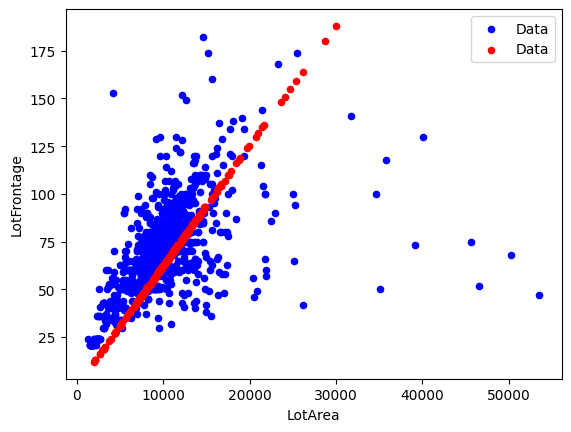

In [14]:
from sklearn.linear_model import LinearRegression

# Eliminate the outliers.
df = df[(df['LotFrontage'] < 200) & (df['LotArea'] < 60000)]

# Extract the lot data.
col = ['LotFrontage', 'LotArea']
lot_df = df[col]
lot_df = lot_df[lot_df.notnull().all(axis=1)]


# Prepare data for linear regression
X = lot_df[['LotArea']]
y = lot_df['LotFrontage']

# Fit linear regression model
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)

# Predict the missing values.
prediction = lr.predict(null_data[['LotArea']])
null_data['LotFrontage'] = prediction.astype(int)

# Eliminate any new outliers.
df = df[(df['LotFrontage'] < 200) & (df['LotArea'] < 60000)]
null_data = null_data[(null_data['LotFrontage'] < 200) & (null_data['LotArea'] < 60000)]

# Plot these two variables.
fig, ax = plt.subplots()
lot_df.plot.scatter(x='LotArea', y='LotFrontage', ax=ax, color='blue', label ='Data')
null_data.plot.scatter(x='LotArea', y='LotFrontage', ax=ax, color='red', label ='Data')

# Create a dataframe with a summary of the nulls.
PrintSummaryOfNulls(df);

#### Alley

In [15]:
# Fill the null Alley's with NA.
print(df[['Alley']].value_counts())
print()
df.loc[:, ['Alley']] = df[['Alley']].fillna('NA')

# Create a dataframe with a summary of the nulls.
PrintSummaryOfNulls(df);

Alley
Grvl     47
Pave     39
Name: count, dtype: int64

       Feature  NumNulls    DType
0   MasVnrType       730   object
1   MasVnrArea         6  float64
2  FireplaceQu       599   object
3  GarageYrBlt        74  float64
4        Fence       968   object
5  MiscFeature      1157   object


#### Masonary Siding Type

The masonary siding type is sparce and may not be of much value.
However, let's fill the nulls with NAs until  we have looked at the correlation coefficients.

In [16]:
# What are the masonary siding types and how much do we have of each type?
print(df[['MasVnrType']].value_counts())
print()
# Fill the NA object with NA strings.
df.loc[:, ['MasVnrType']] = df[['MasVnrType']].fillna('NA')
# df.loc[:, ['MasVnrArea']] = df[['MasVnrArea']].fillna(0)

# Create a dataframe with a summary of the nulls.
PrintSummaryOfNulls(df);

MasVnrType
BrkFace       339
Stone         118
BrkCmn          9
Name: count, dtype: int64

       Feature  NumNulls    DType
0   MasVnrArea         6  float64
1  FireplaceQu       599   object
2  GarageYrBlt        74  float64
3        Fence       968   object
4  MiscFeature      1157   object


#### Fireplace Data

In [17]:
# What are the fireplace qualities.
print(df[['FireplaceQu']].value_counts())
print()

# What is a non-null fireplace count with a null QC?
fireplace_data = df[(df['Fireplaces'] != 0) & (df['FireplaceQu'].isna())][['Fireplaces', 'FireplaceQu']]
print(fireplace_data)
print()

# The null quality data is associated with 0 fireplaces.  Let's set it to NA.
df.loc[:, ['FireplaceQu']] = df[['FireplaceQu']].fillna('NA')

# Create a dataframe with a summary of the nulls.
PrintSummaryOfNulls(df);

FireplaceQu
Gd             321
TA             216
Fa              24
Ex              21
Po              15
Name: count, dtype: int64

Empty DataFrame
Columns: [Fireplaces, FireplaceQu]
Index: []

       Feature  NumNulls    DType
0   MasVnrArea         6  float64
1  GarageYrBlt        74  float64
2        Fence       968   object
3  MiscFeature      1157   object


####  Fence Data

In [18]:
# Let's set nulls in the fence data to 'NoFence'.
df.loc[:, ['Fence']] = df[['Fence']].fillna('NoFence')

# Create a dataframe with a summary of the nulls.
PrintSummaryOfNulls(df);

       Feature  NumNulls    DType
0   MasVnrArea         6  float64
1  GarageYrBlt        74  float64
2  MiscFeature      1157   object


#### Misc Features

Drop the Misc Features column because there are only 39 Misc Features and because the predominate Misc Feature (Shed) doesn't have too much value.  

In [19]:
# Print the count of number of Misc Features.
print(df[['MiscFeature']].value_counts())

df = df.drop(['MiscFeature'], axis=1)


MiscFeature
Shed           36
Othr            2
TenC            1
Name: count, dtype: int64


MSSubClass should be treated as categorical data even though it is provided as numerical data.  The following is the interpretation:
- 20: 1-STORY 1946 & Newer AllStyles
- 30: 1-STORY 1945 & Older
- 40: 1-STORY w/Finished Attic All Ages
- 45: 1-1/2 STORY - Unfinished All Ages
- 50: 1-1/2 STORY Finished All Ages
- 60: 2-STORY 1946 & Newer
- 70: 2-STORY 1945 & Older
- 75: 2-1/2 STORY All Ages
- 80: SPLIT OR MULTI-LEVEL
- 85: SPLIT FOYER
- 90: DUPLEX - All Styles and Ages
- 120: 1-STORY PUD (Planned Unit Development) - 1946 & Newer
- 150: 1-1/2 STORY PUD - All Ages
- 160: 2-STORY PUD - 1946 & Newer
- 180: PUD - MULTILEVEL - Split Level
- 190: 2 FAMILY CONVERSION - All Styles and Ages

In [20]:
# Convert the MSSubClass from a number to categories.

# These are the Ames Housing Classifications
MSSubClassDict = {
    20: '1StoryNew',    # 1946 & Newer AllStyles
    30: '1StoryOld',    # 1945 & Older
    40: '1StoryFin',    # w/Finished Attic All Ages
    45: '1.5StoryUnf',  # Unfinished All Ages
    50: '1.5StoryFin',  # Finished All Ages
    60: '2StoryNew',    # 1946 & Newer
    70: '2StoryOld',    # 1945 & Older
    75: '2.5Story',     # All Ages
    80: 'SplitLvl',     # SPLIT OR MULTI-LEVEL
    85: 'SplitFoy',     # Split Foyer
    90: 'Duplex',       # All Styles and Ages
    120: '1StoryPUD',   # (Planned Unit Development) - 1946 & Newer
    150: '1.5StoryPUD', # All Ages
    160: '2StoryPUD',   # 1946 & Newer
    180: 'PUD Splt-lvl', # Split Level PUD
    190: '2FamConv'}    # 2 FAMILY CONVERSION - All Styles and Ages

df['MSSubClass'] = df['MSSubClass'].map(MSSubClassDict)
print(df['MSSubClass'].sample(10))


Id
379       1StoryNew
1127      1StoryPUD
977       1StoryOld
326     1.5StoryUnf
333       1StoryNew
1328      1StoryNew
462       2StoryOld
1240      1StoryNew
228       2StoryPUD
897       1StoryOld
Name: MSSubClass, dtype: object


## EDA
Goals:
* Univariate Analysis
    * Price
    * Other Columns
* Bivariate Analysis
    * Graphical Summaries
    * Numerical Summaries

### Univariate Analysis
Plot the distribution of values for each categorical feature.

#### Univariate Analysis of Categorical Features

In [21]:
# List all categorical columns.
df.select_dtypes(include='object').agg(['nunique'])

MSSubClass  MSZoning  Street  Alley  LotShape  LandContour  \
nunique          15         5       2      3         4            4   

         Utilities  LotConfig  LandSlope  Neighborhood  ...  Functional  \
nunique          1          5          3            25  ...           6   

         FireplaceQu  GarageType  GarageFinish  GarageQual  GarageCond  \
nunique            6           7             4           6           6   

         PavedDrive  Fence  SaleType  SaleCondition  
nunique           3      5         9              6  

[1 rows x 42 columns]

Make 2 passes at generating categorical distributions.  
The first pass will be to generate individual plots for saving and not displaying.
The second pass will be to generate plots 2 at a time for displaying.

In [22]:
# Create a formatter for currency
# '${x:,.2f}' means:
# $ - prepends a dollar sign
# , - adds a comma as a thousands separator
# .2f - formats the number with two decimal places
usd_formatter = mtick.StrMethodFormatter('${x:,.0f}')

In [23]:
#  The following is commented out, because dual plots are displayed down below.
#  Uncomment this code to make and save individual categorical distribution plots.

if False:  
    # Create and save individual plots for the categorical distributions
    categories = df.select_dtypes(include='object').columns
    for col in categories:
        plt.figure(figsize=(8, 5)) # Create a new figure for each plot
        plt.ticklabel_format(axis='y', useLocale=True)    
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        ax = plt.gca()
    #    ax.yaxis.set_major_formatter(usd_formatter)
        plt.xlabel(col)
        plt.ylabel('Count')
        if col == 'region':
            plt.xticks([])
        else:
            plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.savefig(f'images/{col} Distribution.jpg');
    

There are 42 categories.


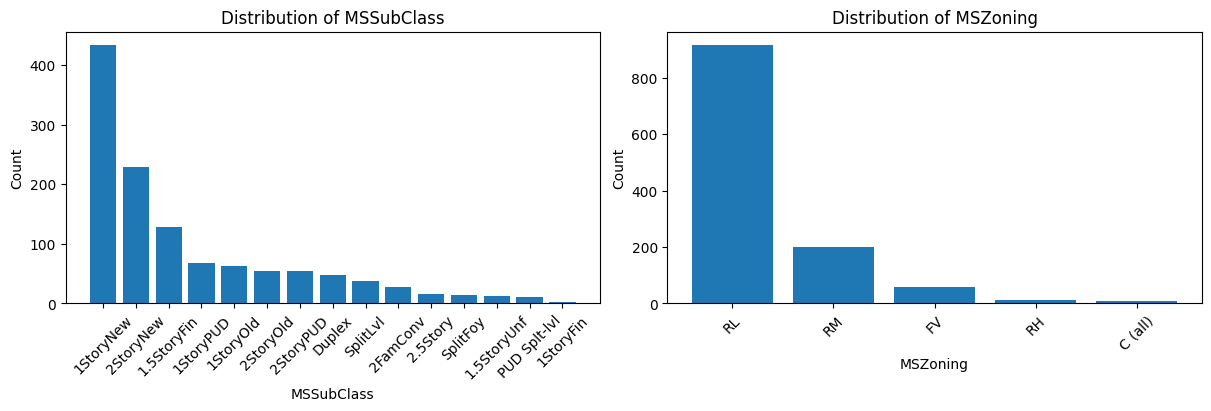

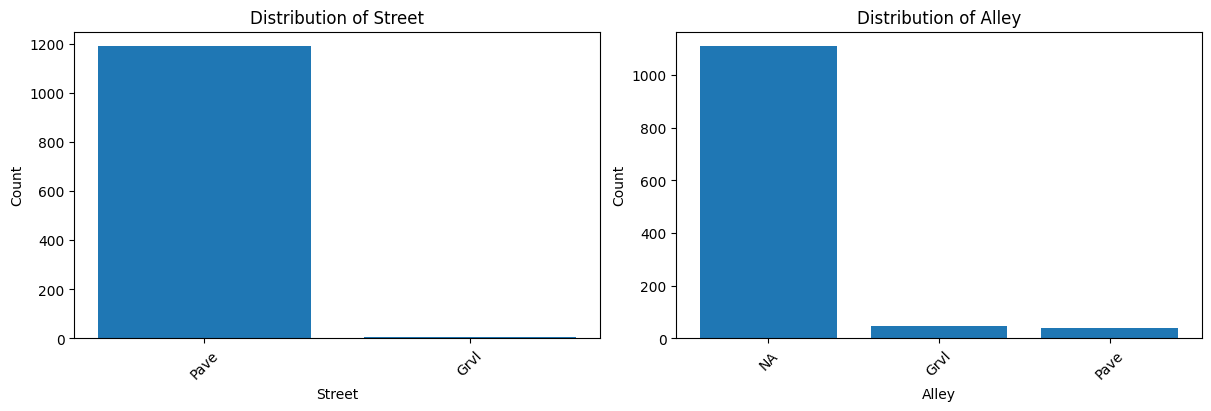

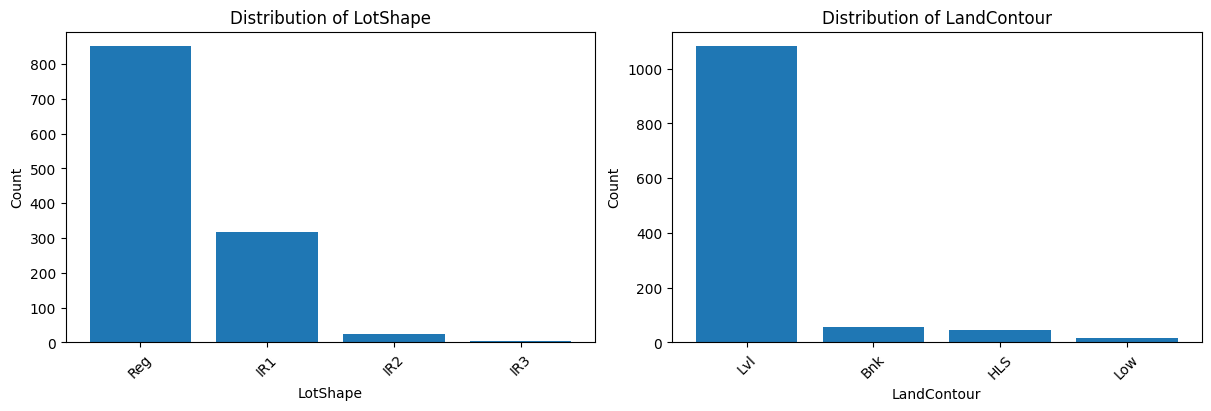

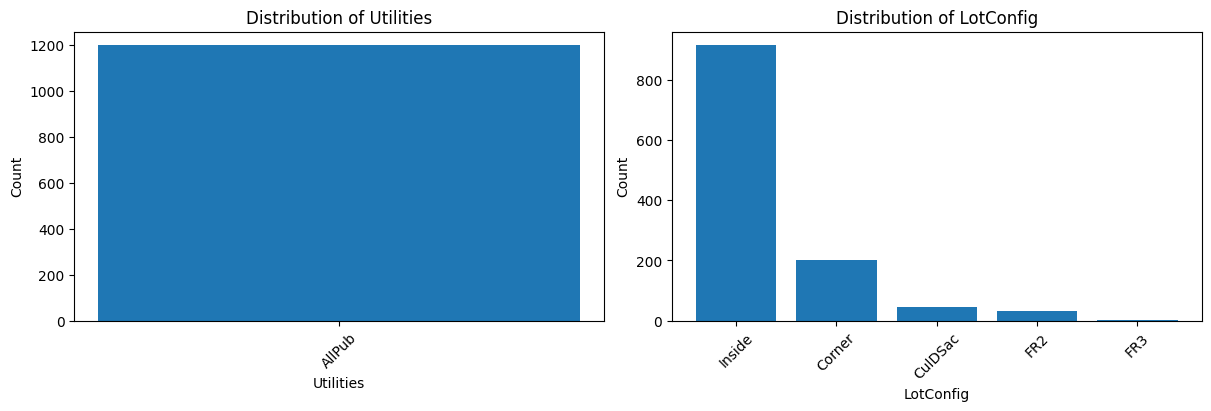

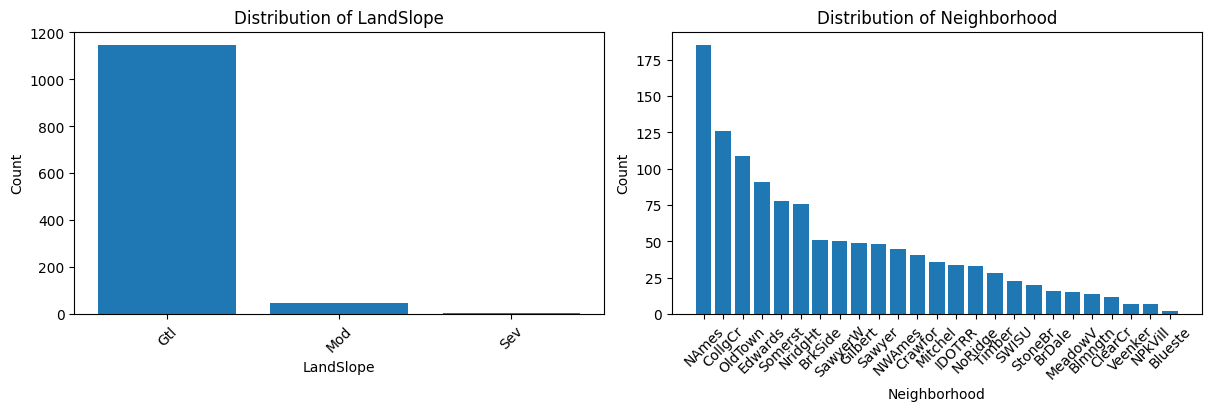

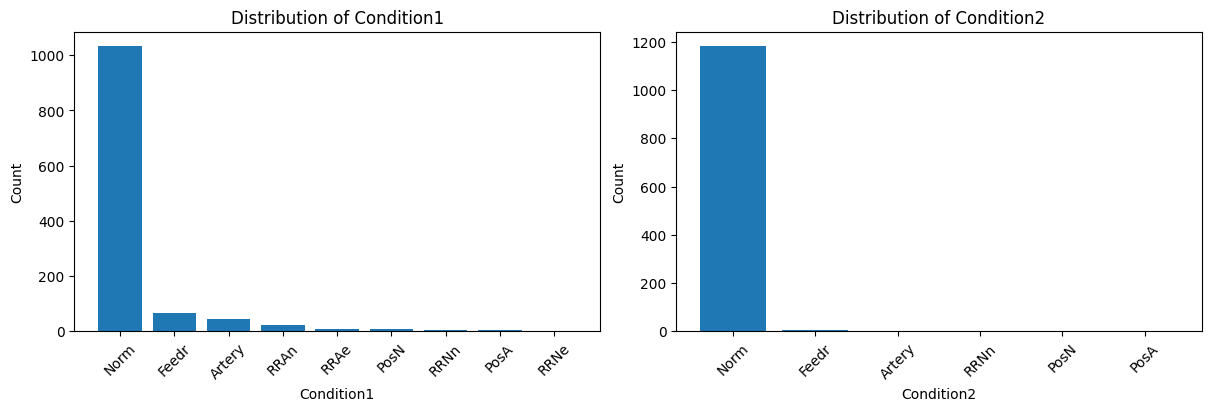

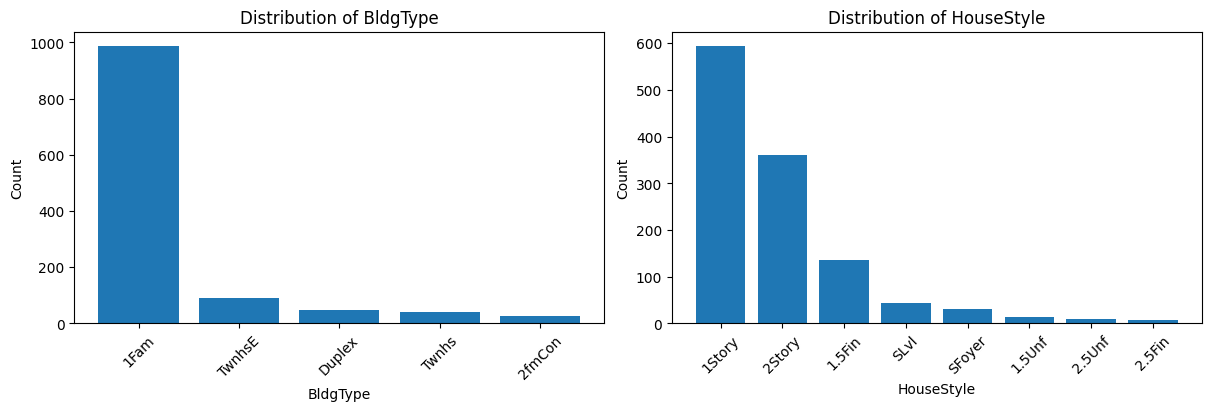

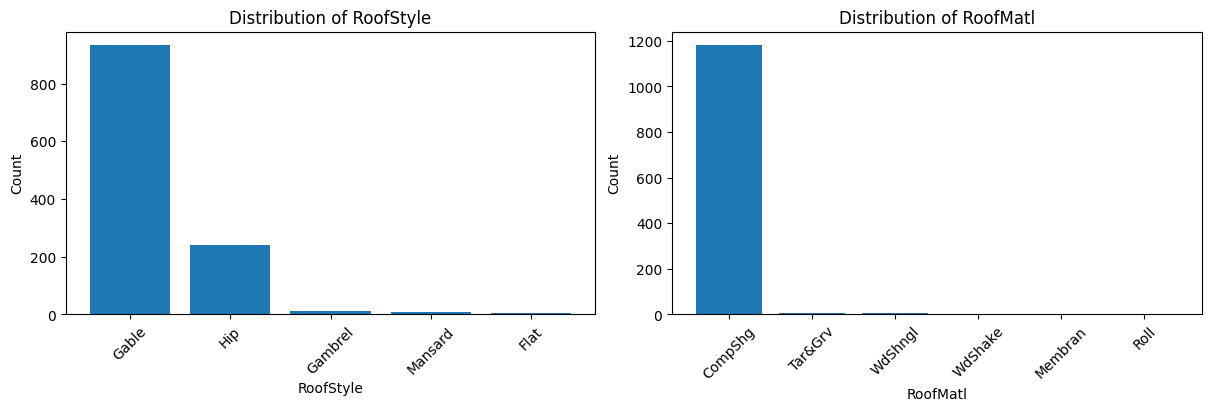

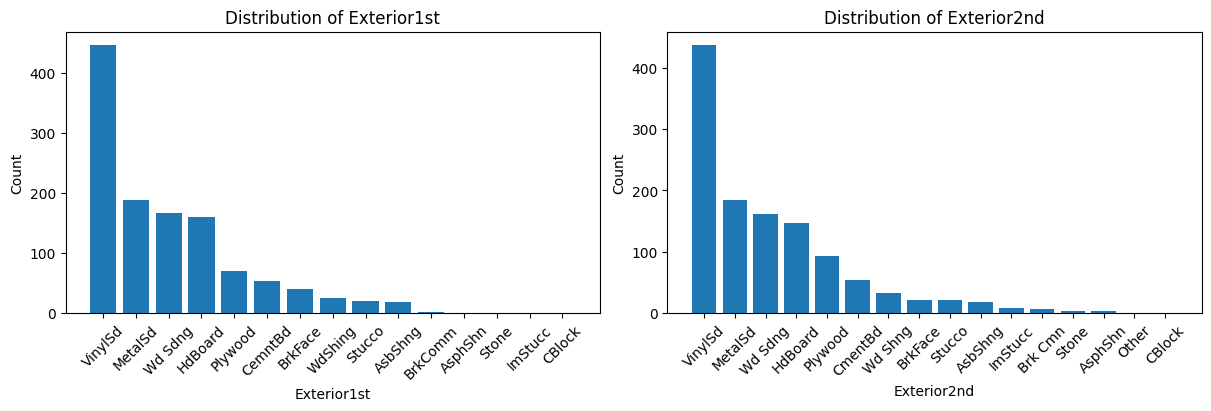

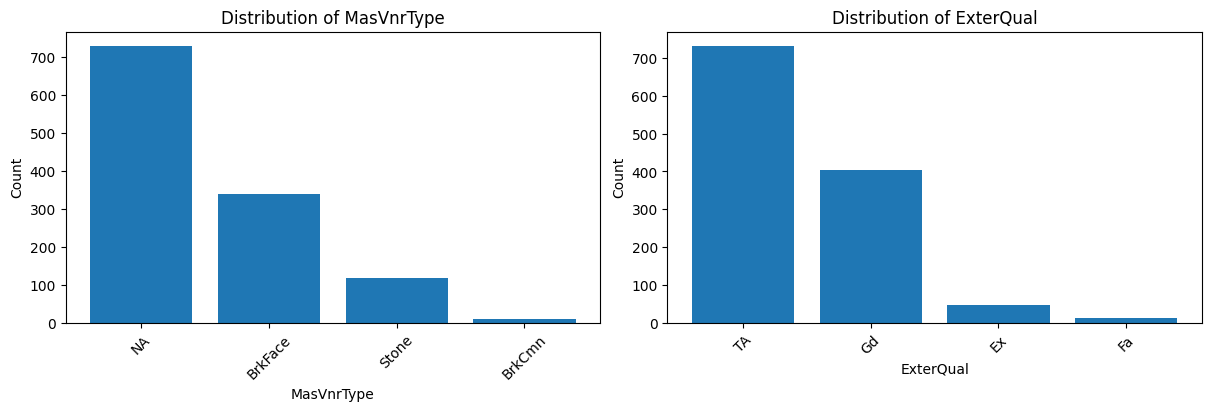

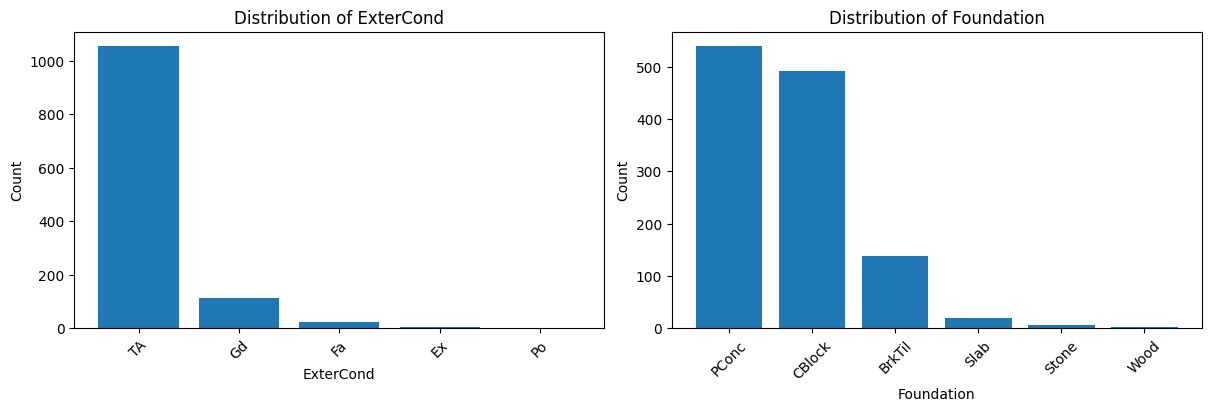

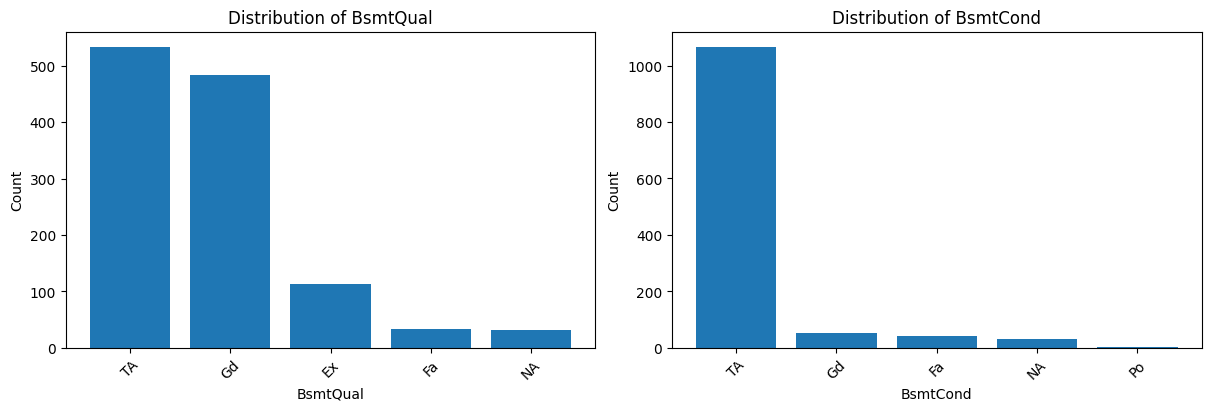

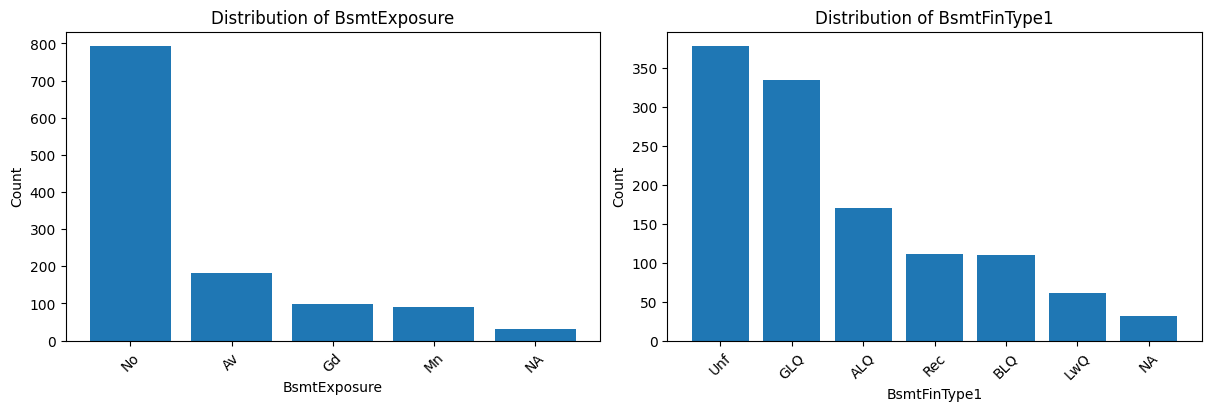

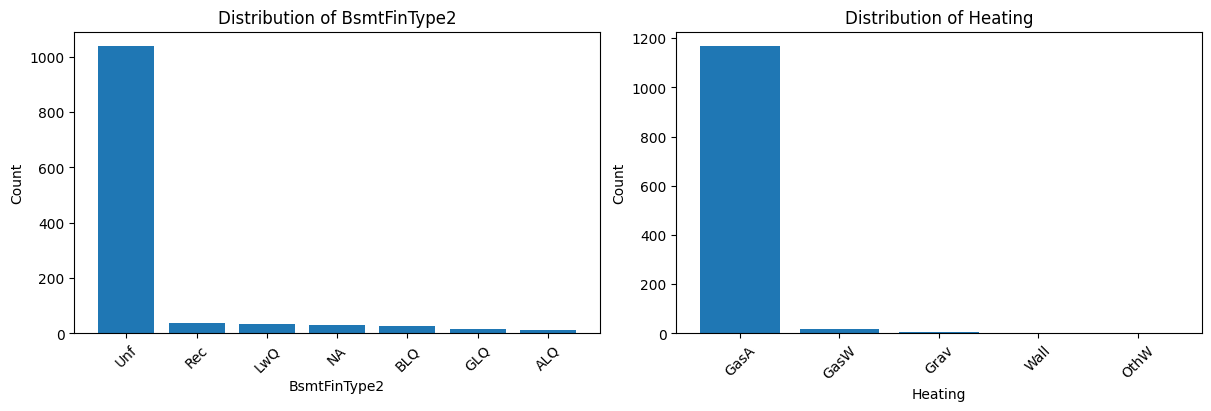

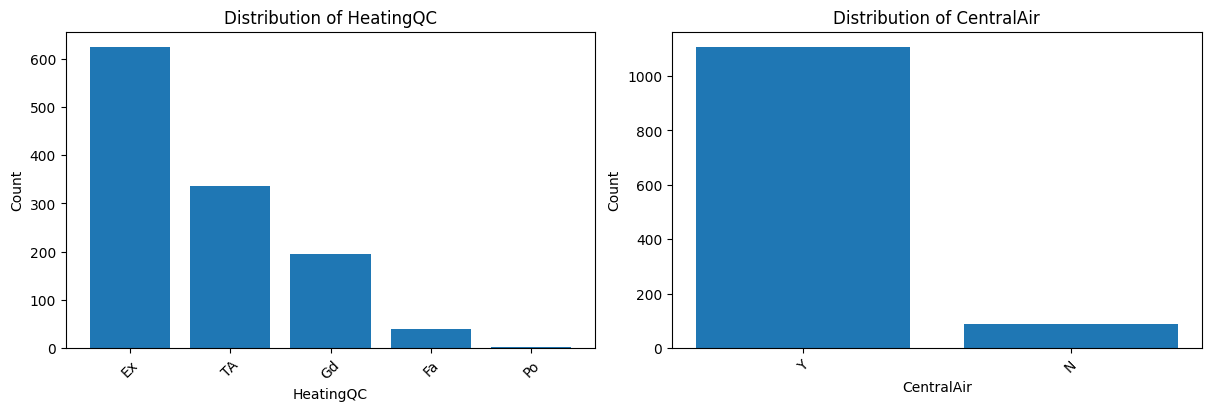

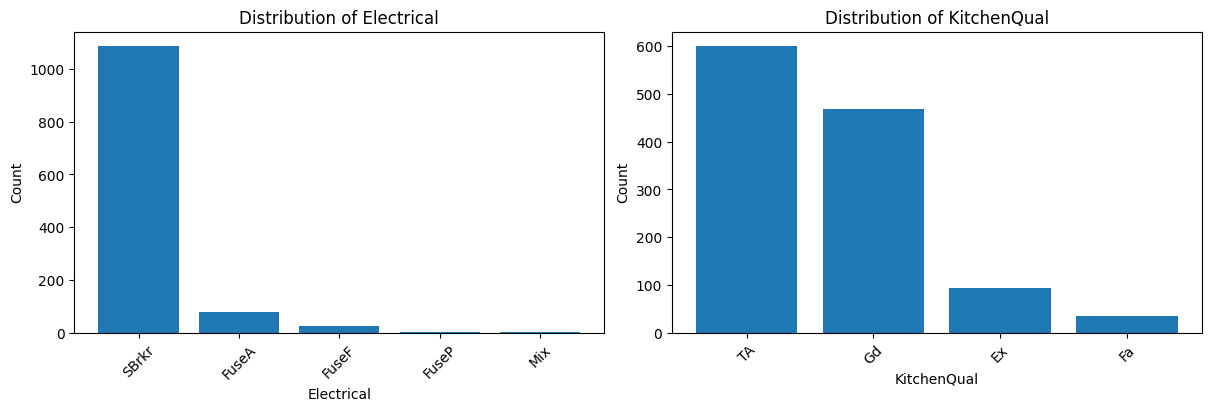

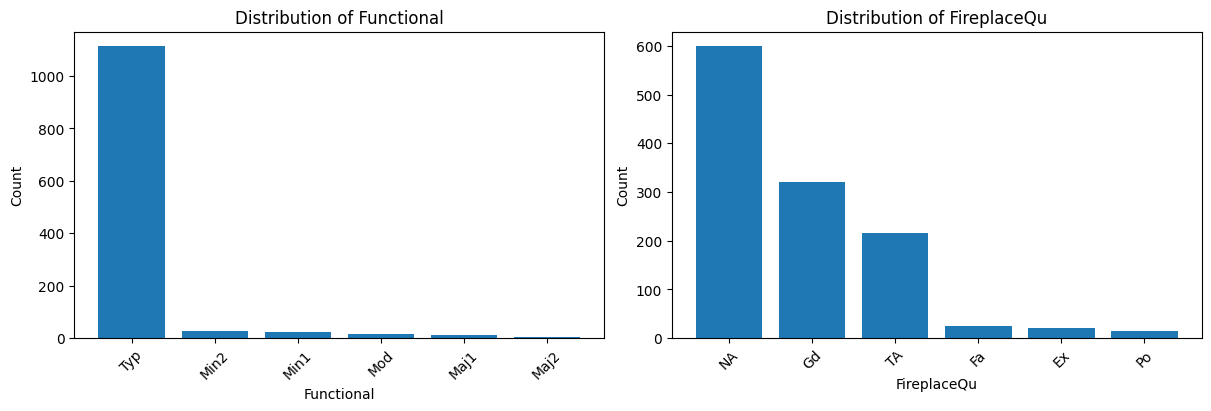

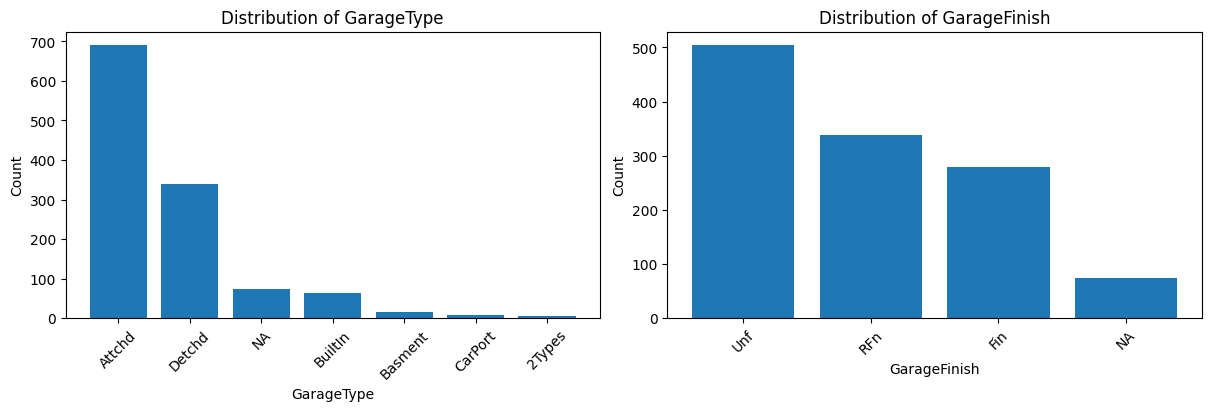

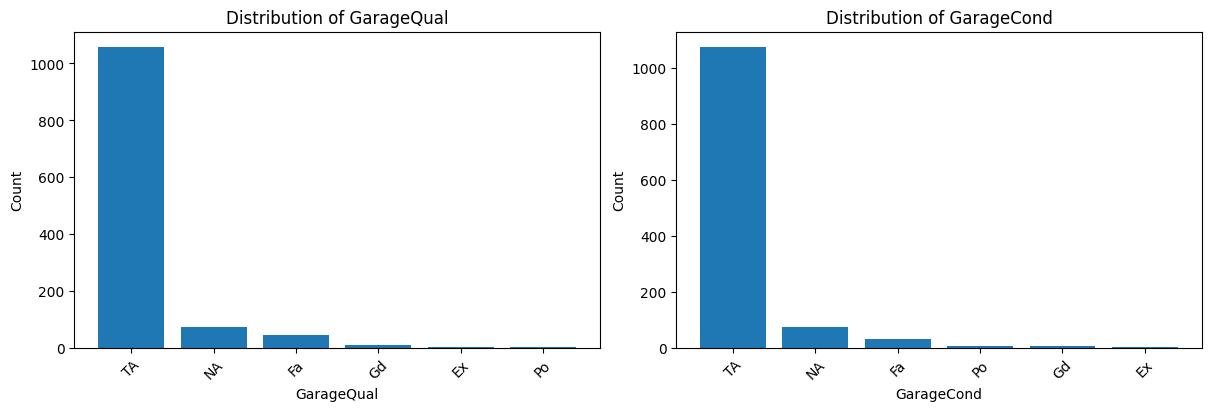

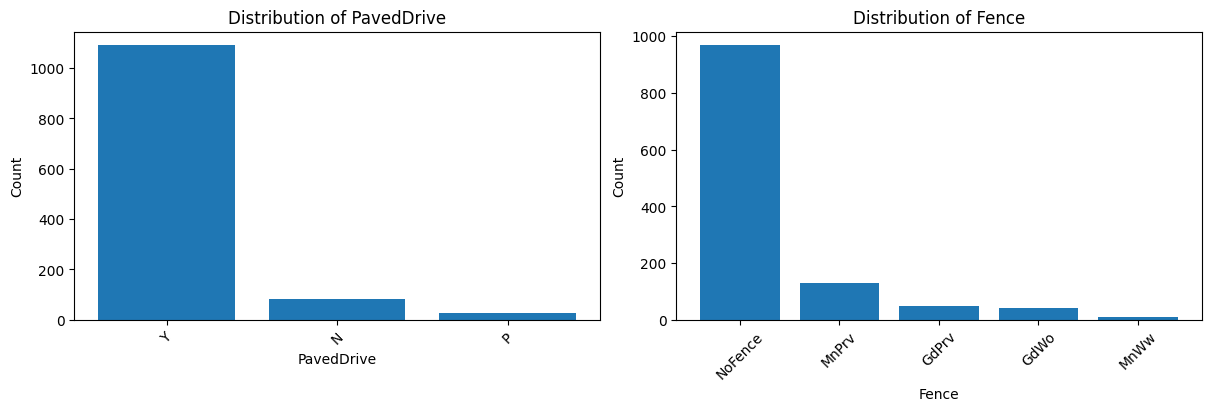

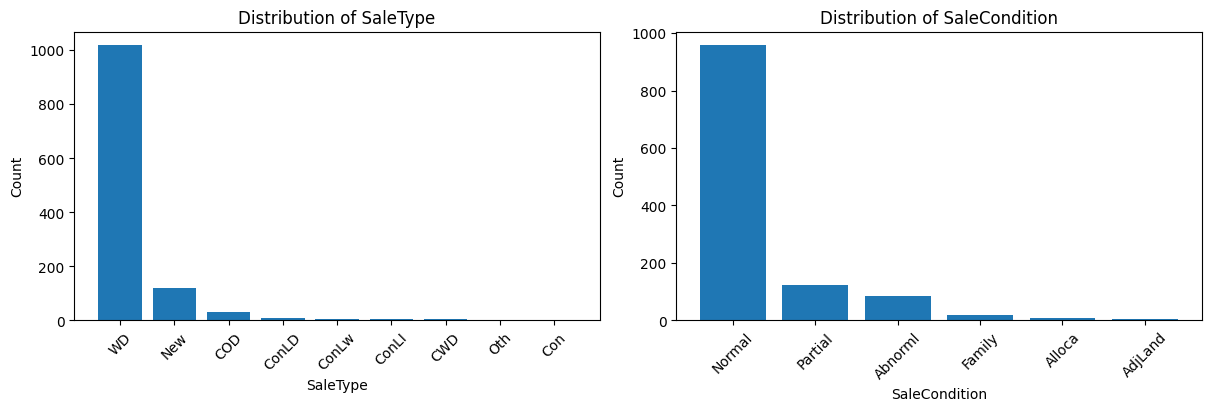

In [24]:
# Get the list of categorical column names.
categories = df.select_dtypes(include='object').columns
print(f"There are {len(categories)} categories.")

# Find out how many plots to make
num_cat = len(categories)
num_col = 2
num_row = np.ceil(num_cat / num_col)
plot_col = 0
extra_plot = False

# If the last plot will not be a pair of plots,
if num_cat != num_col * num_row:
    extra_plot = True

for col in categories:
    # If this is the left-hand plot,
    if plot_col == 0:
        fig, axs = plt.subplots(1, num_col, figsize=(12, 4), constrained_layout=True) # Create a new figure for each 3 plots

    # Create the current sub-plot.
    value_cnts = df[col].value_counts()
    axs[plot_col].bar(value_cnts.index, value_cnts.values)
    axs[plot_col].ticklabel_format(axis='y', useLocale=True)    
    axs[plot_col].set_title(f'Distribution of {col}')
    axs[plot_col].set_xlabel(col)
    axs[plot_col].set_ylabel('Count')
    axs[plot_col].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels for readability

    # Advance to the next plot.
    plot_col += 1
    if plot_col == num_col:
        plot_col = 0
        # Save and show the plot.
        plt.show();

# If there is an extra plot,
if extra_plot == True:
    # Make the last plot not visible.
    axs[plot_col].set_visible(False)
    # Save and show the last plot plot.
    plt.savefig(f'images/{col} Distribution.jpg')
    plt.show();


MSZoning Codes: 
    C - Commercial, 
    FV - Floating Village Residential, 
    RH - Residential High Density, 
    RL - Residential Low Density, 
    RM - Residential Medium Density

In [25]:
# Street, Utilities, Condition2, Roofmatl, and Heating columns look like they are virtually all one value.
# Ergo, let's drop them.
# HouseStyle looks like a less-detailed version of MSSubClass.  Let's drop it as well.
df.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'HouseStyle'], axis=1, inplace=True)


In [26]:
print(df.shape)

# Normally, we would want to drop categorical values that had a 'small' number of values.
# However, doing that for this data set would result in no rows.

# If there are too few values for any value type in a category, the test dataset might contain a value that was not in the training set.
# Thus, if there are fewer than 100 values for any category, merge these categories into an Other category.
# (Note:  Rare values can cause a problem if they showup in the test data without being in the training data.)
categories = df.select_dtypes(include='object').columns
for col in categories:
    df2 = df[col].value_counts().to_frame()
    for value, row in df2.iterrows():
        count = row.iloc[0]
        if count < 100:
            df.loc[df[col] == value, col] = 'Other'
            print(f"Changed {count} instances of {col} \t == {value} \t to Other")

print(df.shape)

(1196, 71)
Changed 67 instances of MSSubClass 	 == 1StoryPUD 	 to Other
Changed 63 instances of MSSubClass 	 == 1StoryOld 	 to Other
Changed 55 instances of MSSubClass 	 == 2StoryOld 	 to Other
Changed 55 instances of MSSubClass 	 == 2StoryPUD 	 to Other
Changed 47 instances of MSSubClass 	 == Duplex 	 to Other
Changed 37 instances of MSSubClass 	 == SplitLvl 	 to Other
Changed 27 instances of MSSubClass 	 == 2FamConv 	 to Other
Changed 15 instances of MSSubClass 	 == 2.5Story 	 to Other
Changed 14 instances of MSSubClass 	 == SplitFoy 	 to Other
Changed 12 instances of MSSubClass 	 == 1.5StoryUnf 	 to Other
Changed 10 instances of MSSubClass 	 == PUD Splt-lvl 	 to Other
Changed 3 instances of MSSubClass 	 == 1StoryFin 	 to Other
Changed 57 instances of MSZoning 	 == FV 	 to Other
Changed 13 instances of MSZoning 	 == RH 	 to Other
Changed 10 instances of MSZoning 	 == C (all) 	 to Other
Changed 47 instances of Alley 	 == Grvl 	 to Other
Changed 39 instances of Alley 	 == Pave 	 to Oth

#### Univariate Analysis of Numeric Features
Plot the distributions of numeric features.

First, convert year columns into age.

In [27]:
# Convert YearBuilt to Age but keep the 0's
df['Age'] = 2010 - df['YearBuilt']
df.loc[df['YearBuilt'] == 0, 'Age'] = 0
df.drop(['YearBuilt'], axis=1, inplace=True)

# Convert YrSold to SaleAge but keep the 0's
df['SaleAge'] = 2010 - df['YrSold']
df.loc[df['YrSold'] == 0, 'SaleAge'] = 0
df.drop(['YrSold'], axis=1, inplace=True)

# Convert YearRemodAdd to RemodAge but keep the 0's
df['RemodAge'] = 2010 - df['YearRemodAdd']
df.loc[df['YearRemodAdd'] == 0, 'RemodAge'] = 0
df.drop(['YearRemodAdd'], axis=1, inplace=True)

# Convert GarageYrBlt to GarageAge but keep the 0's
df['GarageAge'] = 2010 - df['GarageYrBlt']
df.loc[df['GarageYrBlt'] == 0, 'GarageAge'] = 0
df.drop(['GarageYrBlt'], axis=1, inplace=True)


##### Analysis of Output Variable:  SalePrice

In [28]:
# List all numeric columns.
num_col = df.select_dtypes(include=np.number).columns.to_list()
print(f"There are {len(num_col)} numeric features.")
num_features = num_col
num_features.remove('SalePrice')
print(num_features)

There are 35 numeric features.
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'Age', 'SaleAge', 'RemodAge', 'GarageAge']


Discard price outliers (< 2nd percentile or > 98th percentile) and then plot distribution.

count      1196.0
mean     180502.0
std       83303.0
min       34900.0
2%        75950.0
5%        86750.0
10%      103100.0
20%      120000.0
50%      159000.0
80%      232000.0
90%      284500.0
95%      337125.0
98%      402875.0
max      755000.0
Name: SalePrice, dtype: float64


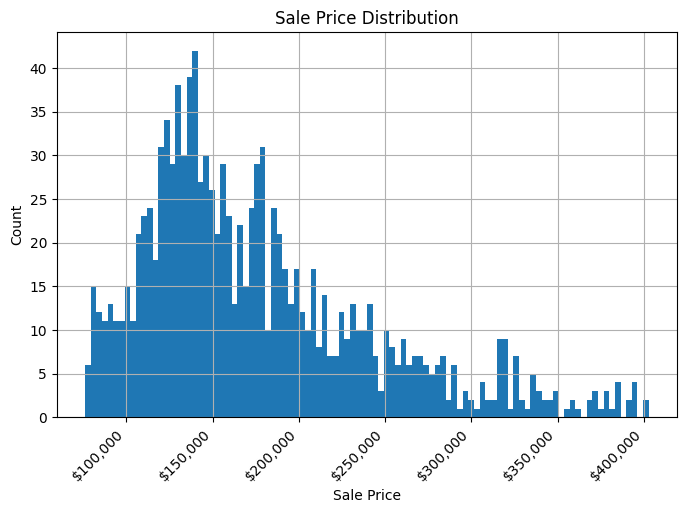

In [29]:
# Describe the distribution of the prices.
print(df['SalePrice'].describe([0.02, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.98]).round(0))

# Eliminate the bottom 2% and top 2%.
lower_threshold = df['SalePrice'].quantile(0.02)
df = df[df['SalePrice'] >= lower_threshold] 
upper_threshold = df['SalePrice'].quantile(0.98)
df = df[df['SalePrice'] < upper_threshold] 

df['SalePrice'].hist(bins=100, figsize=(8,5))
plt.title(f'Sale Price Distribution')
# Apply the formatter to the y-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(usd_formatter)
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.savefig(f'images/SalePriceDistribution.jpg');


##### Analysis of Numeric Features (Other Than Price)
Plot the distribution of numeric features other than the output variable.

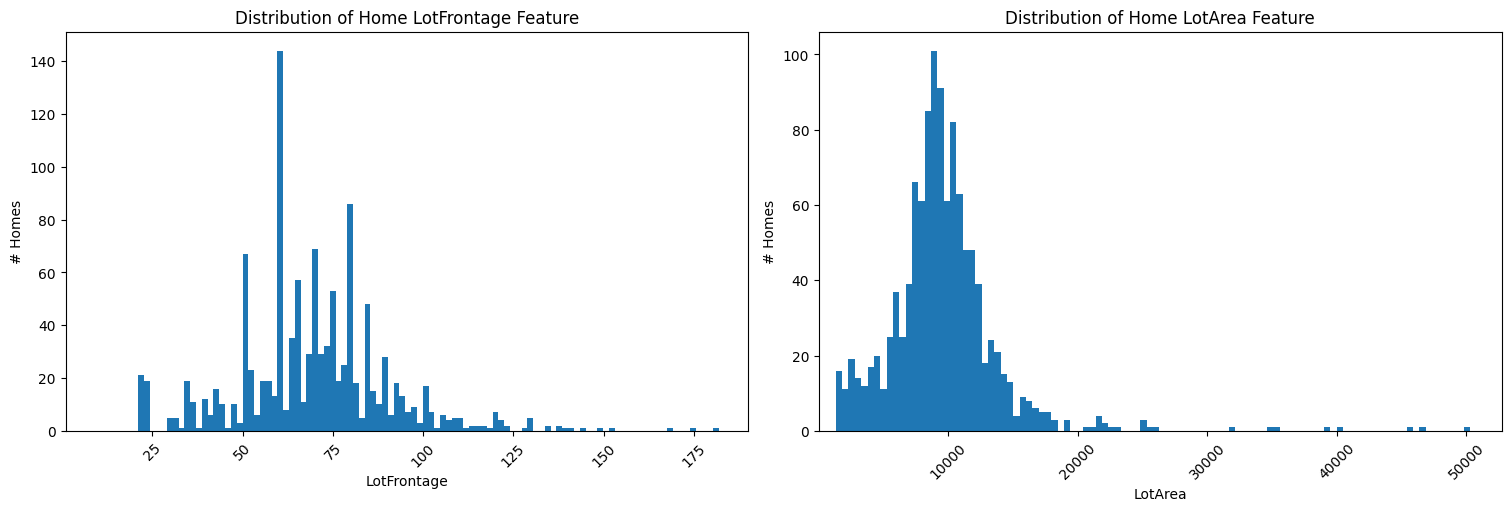

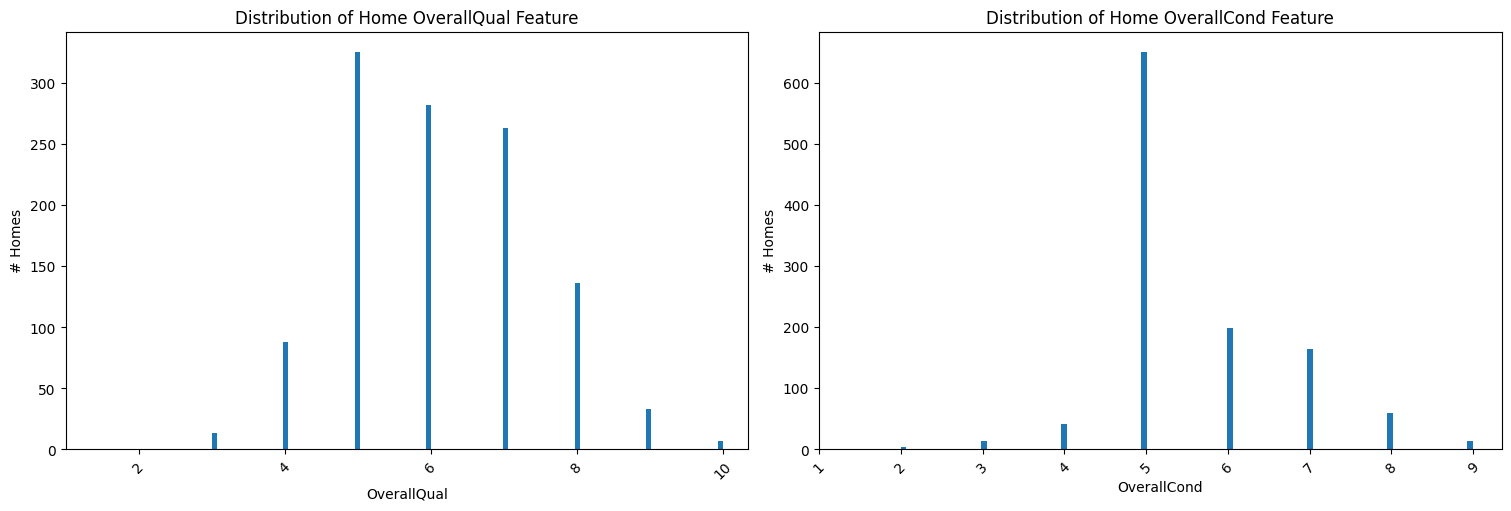

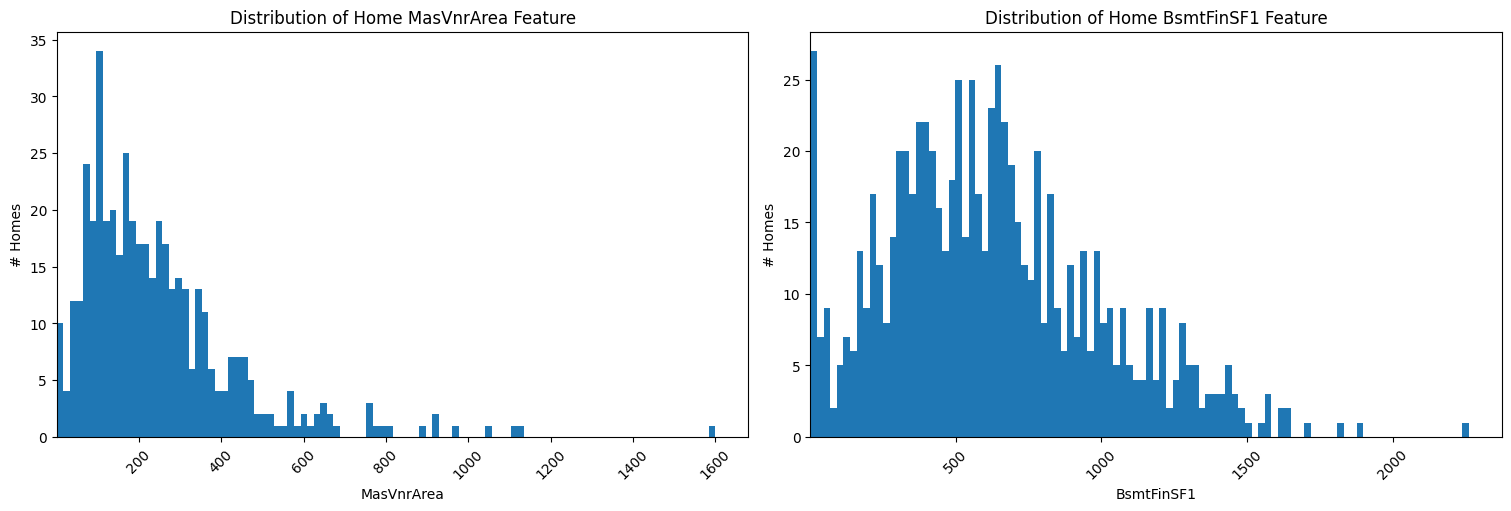

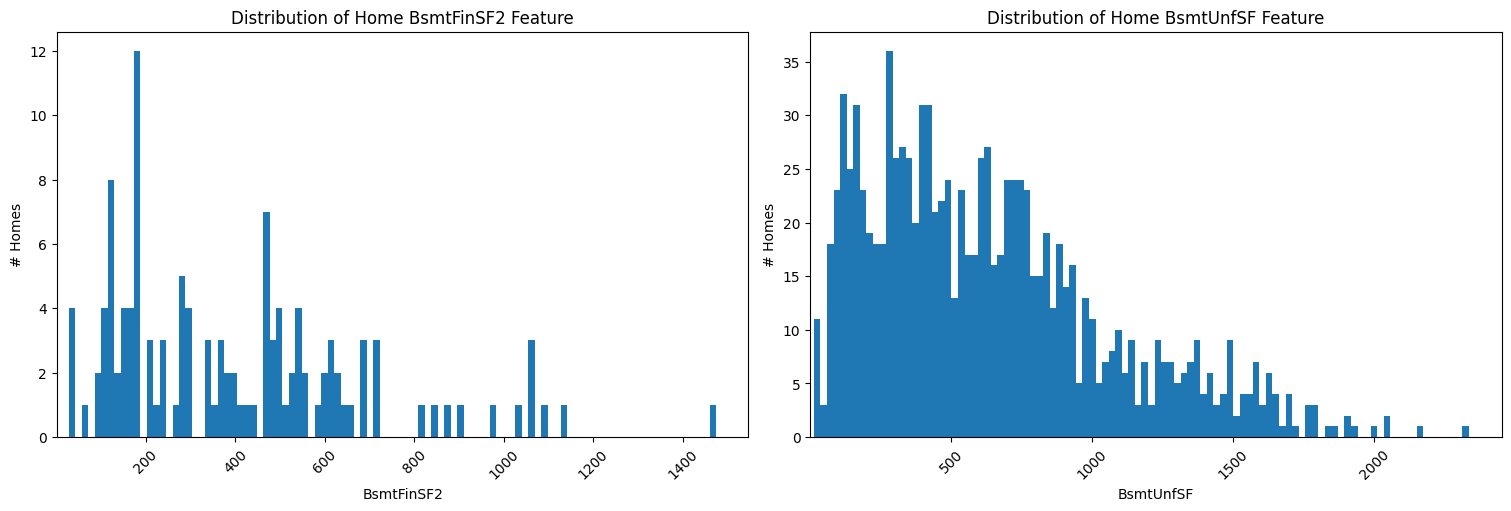

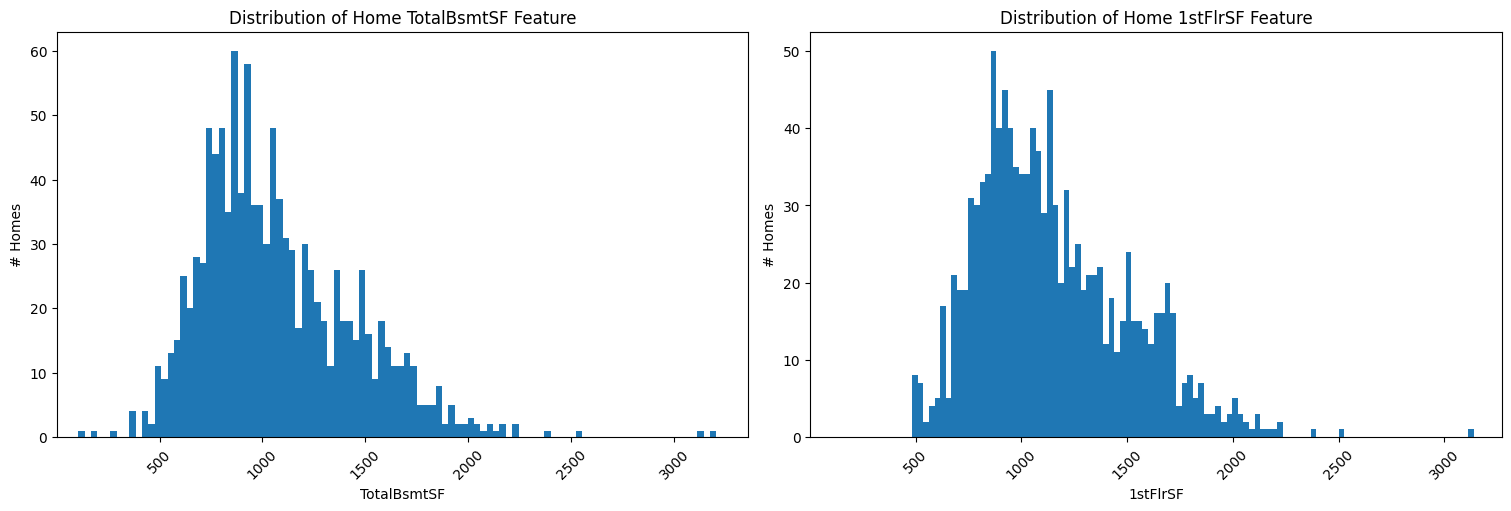

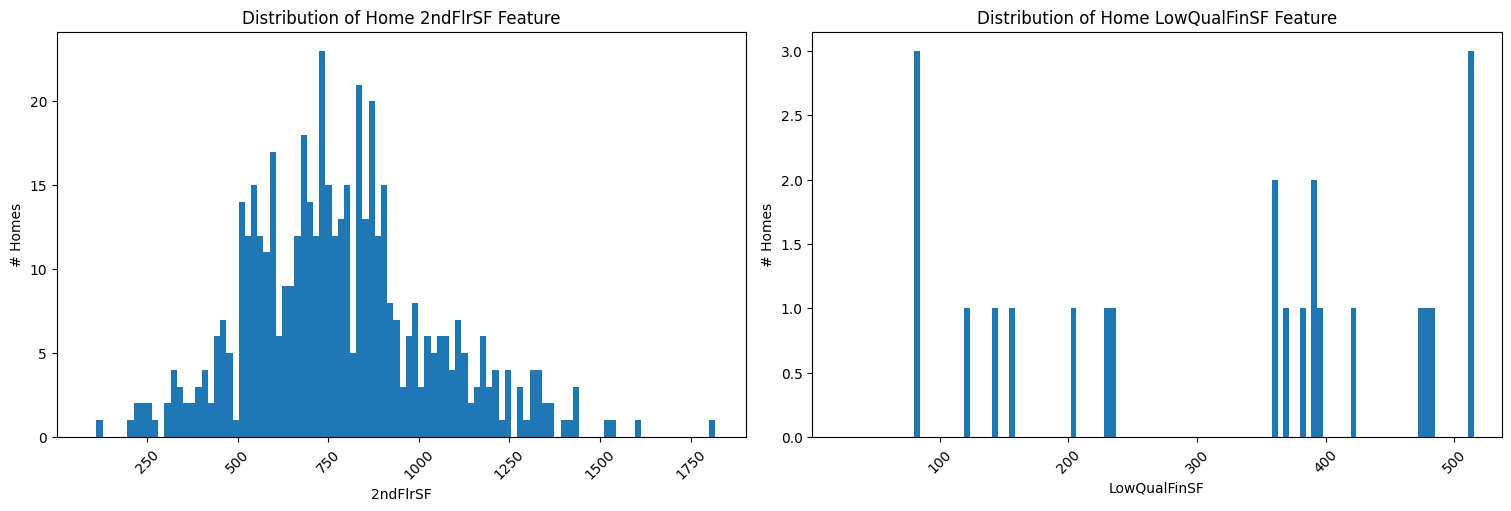

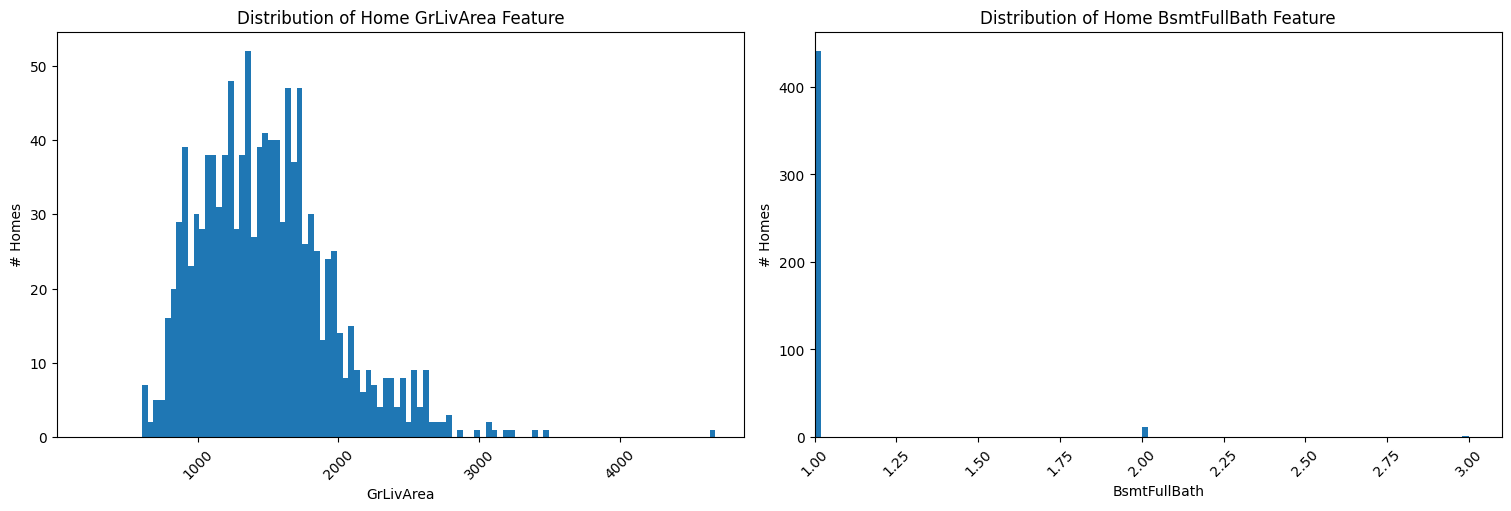

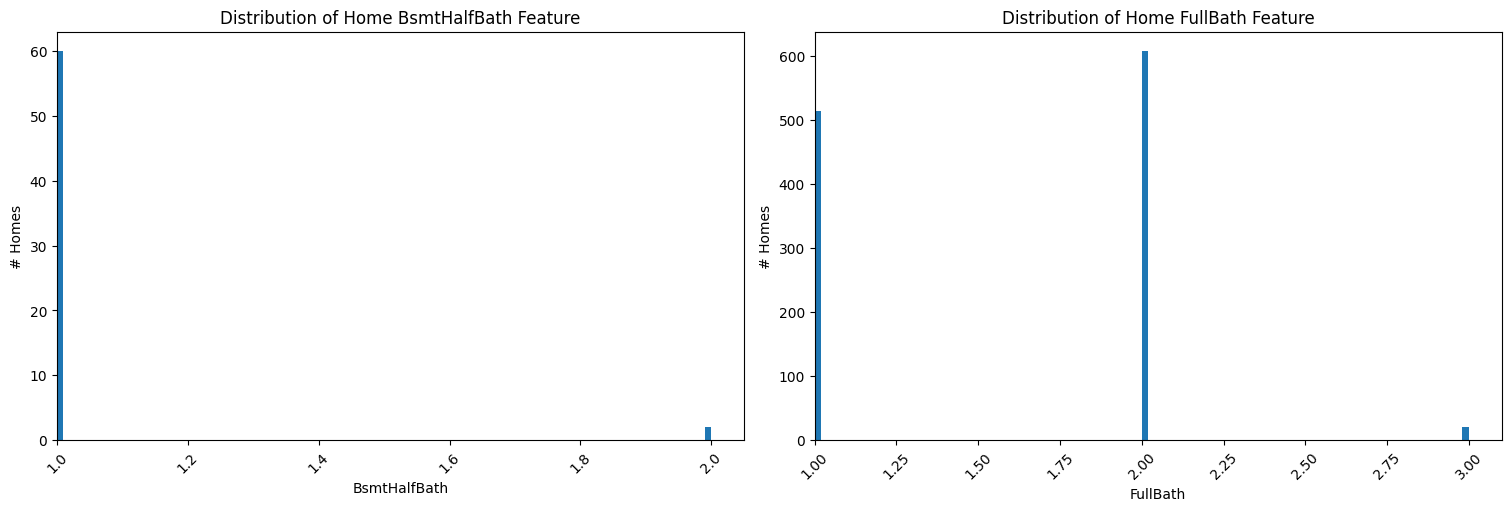

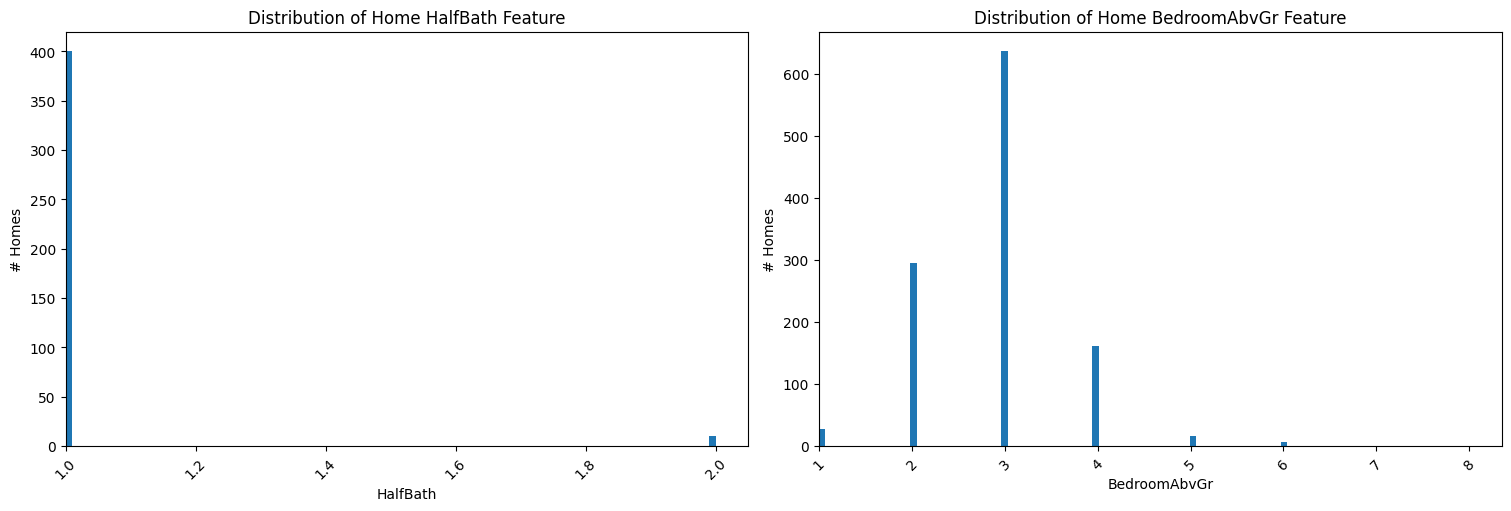

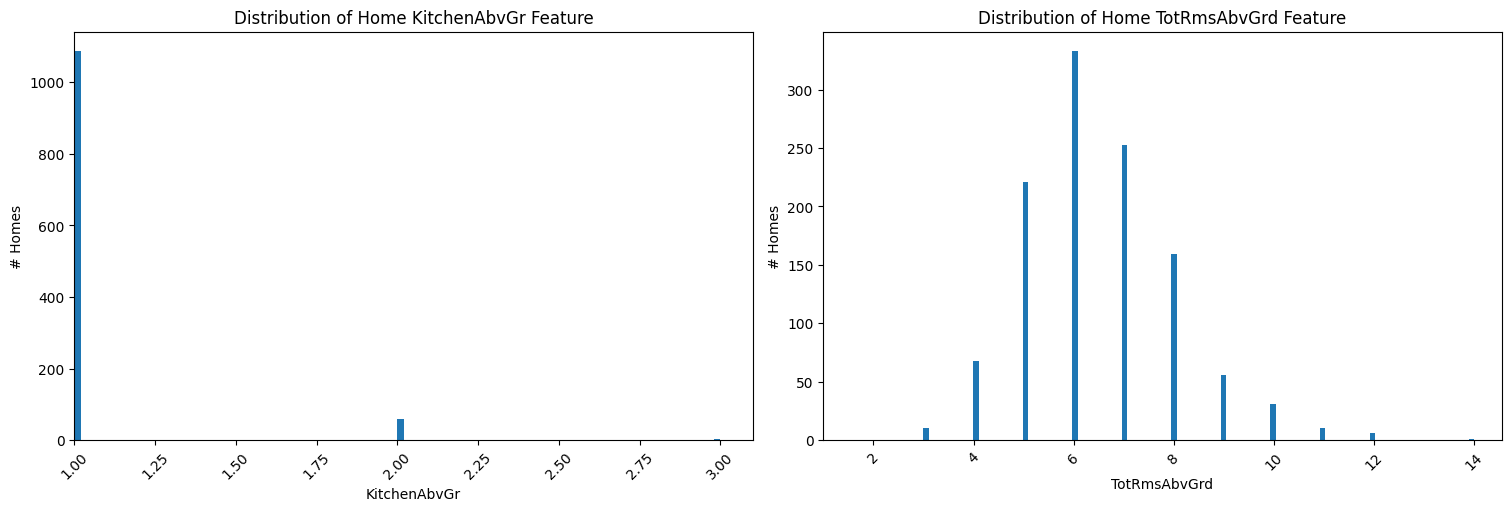

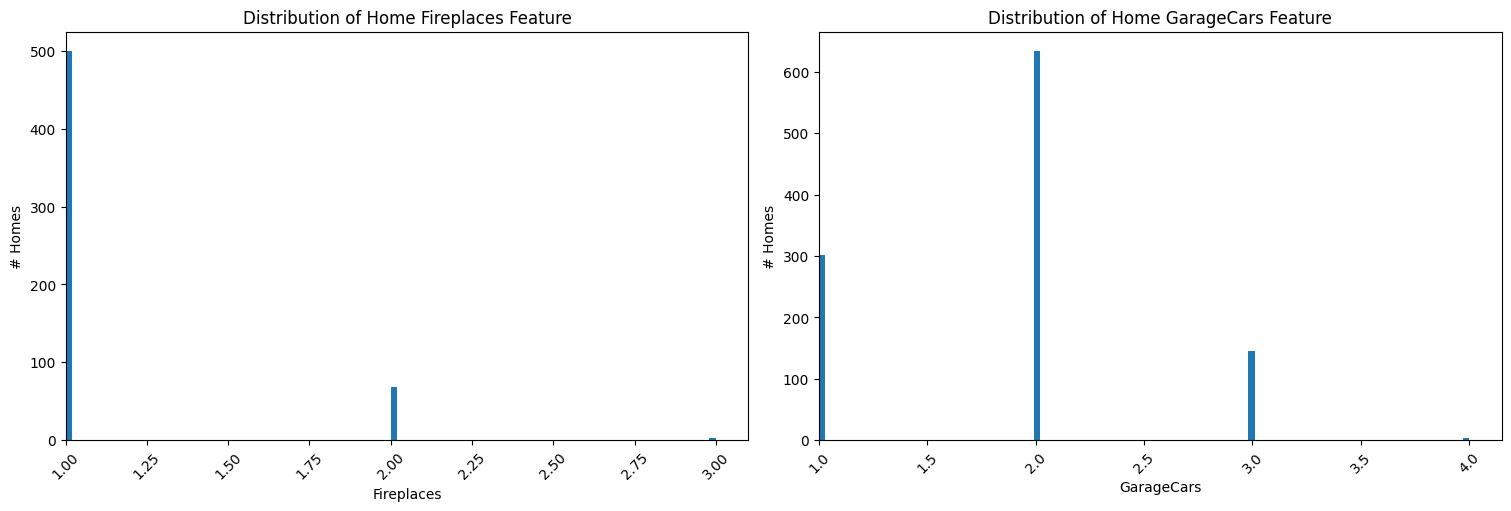

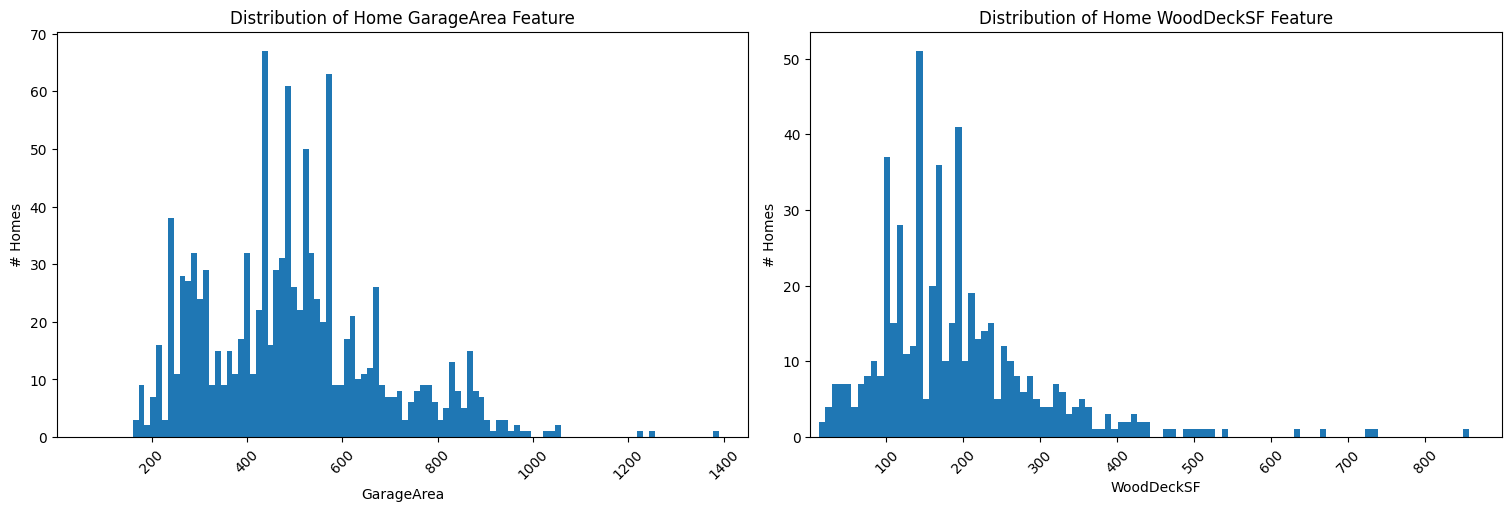

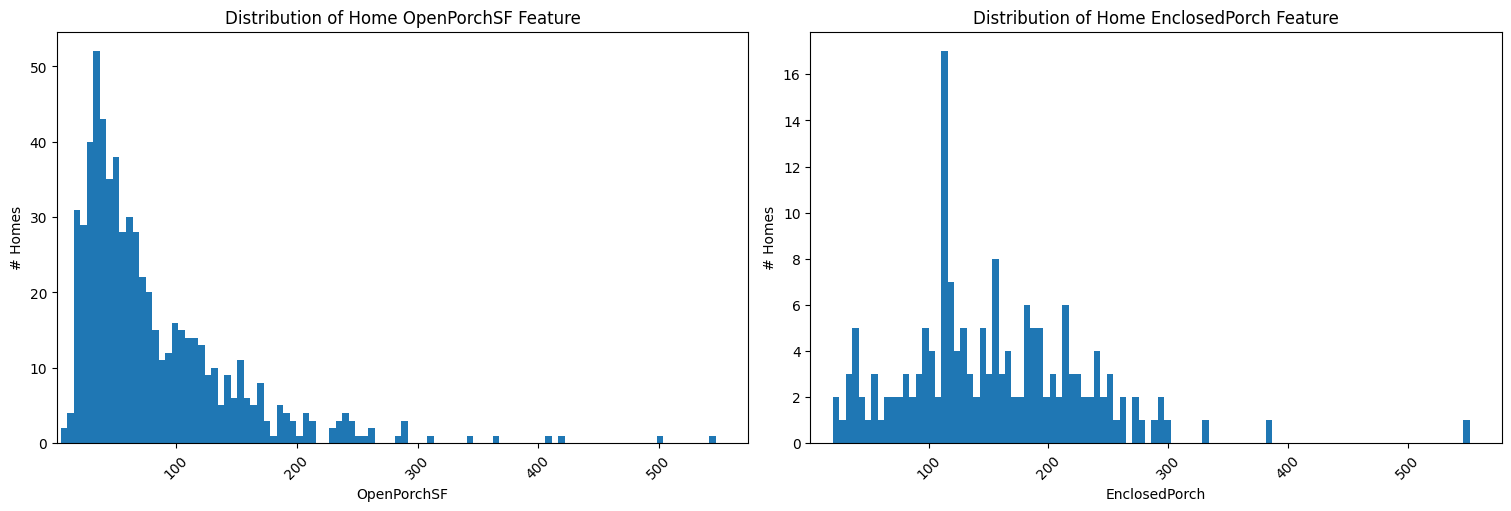

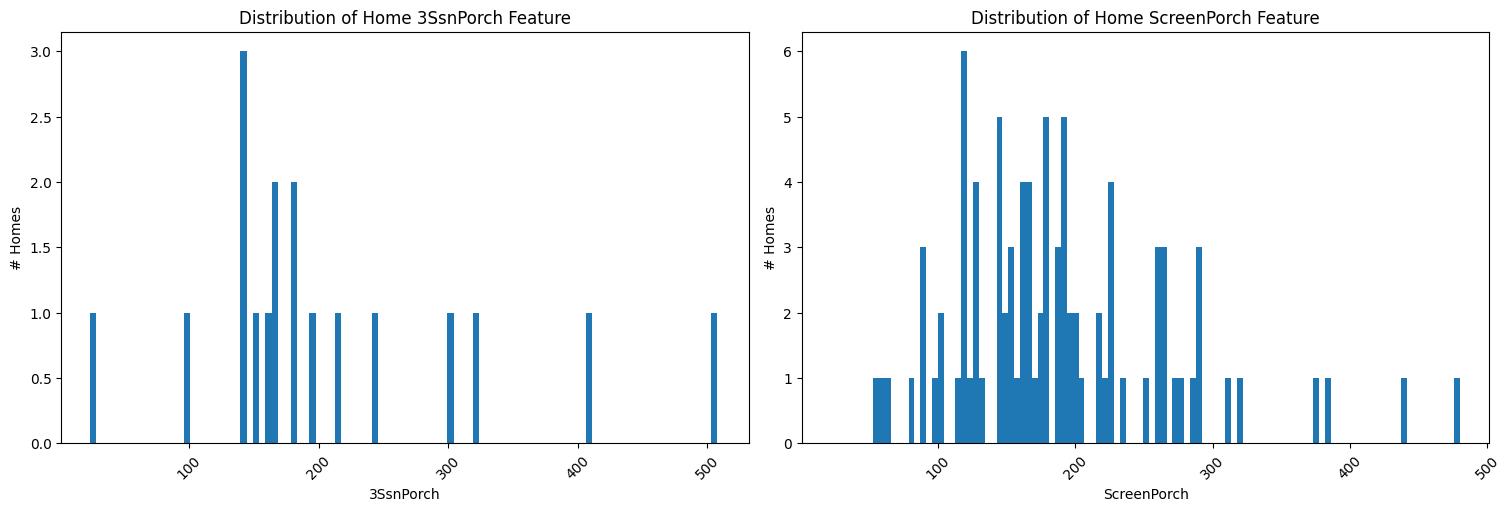

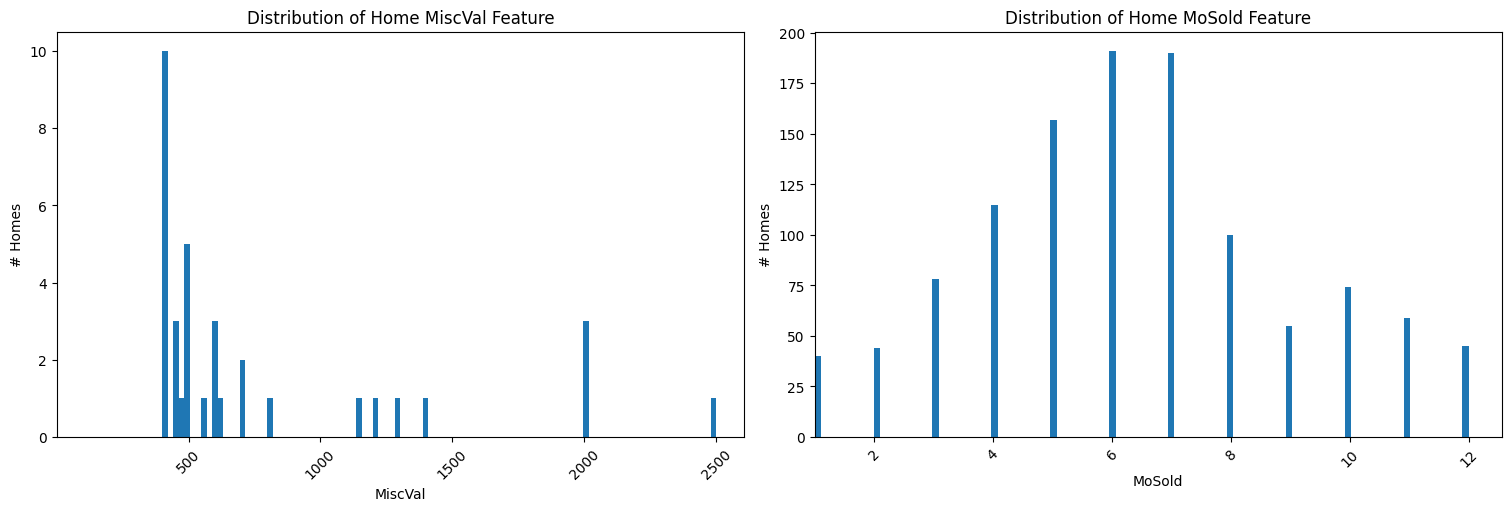

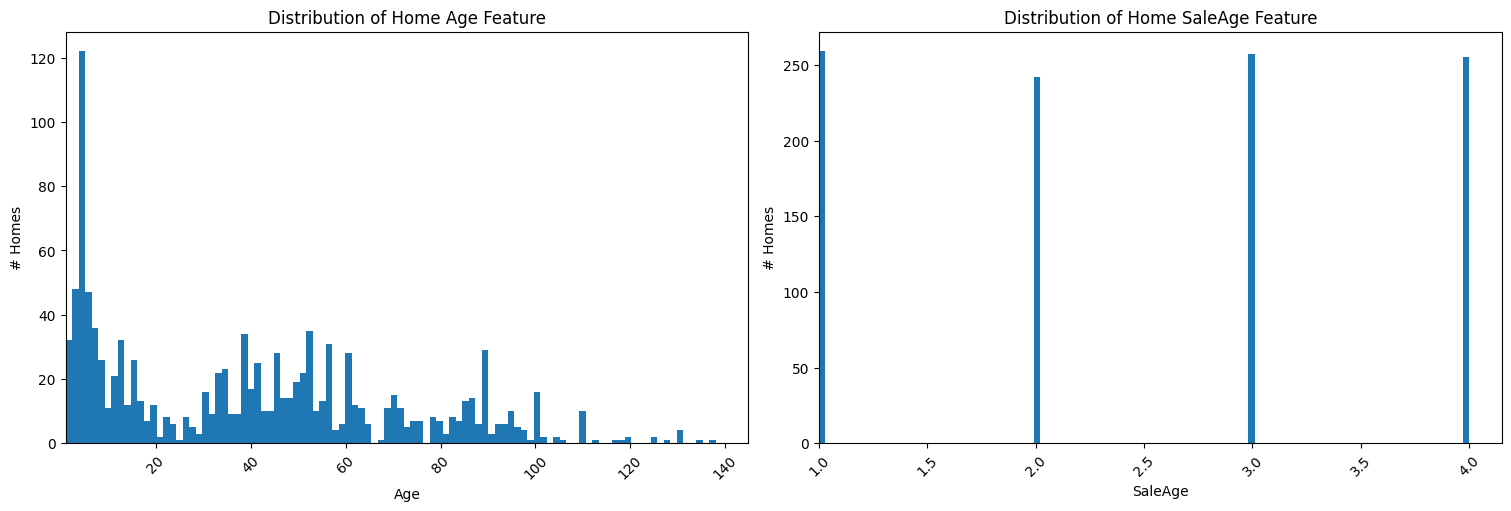

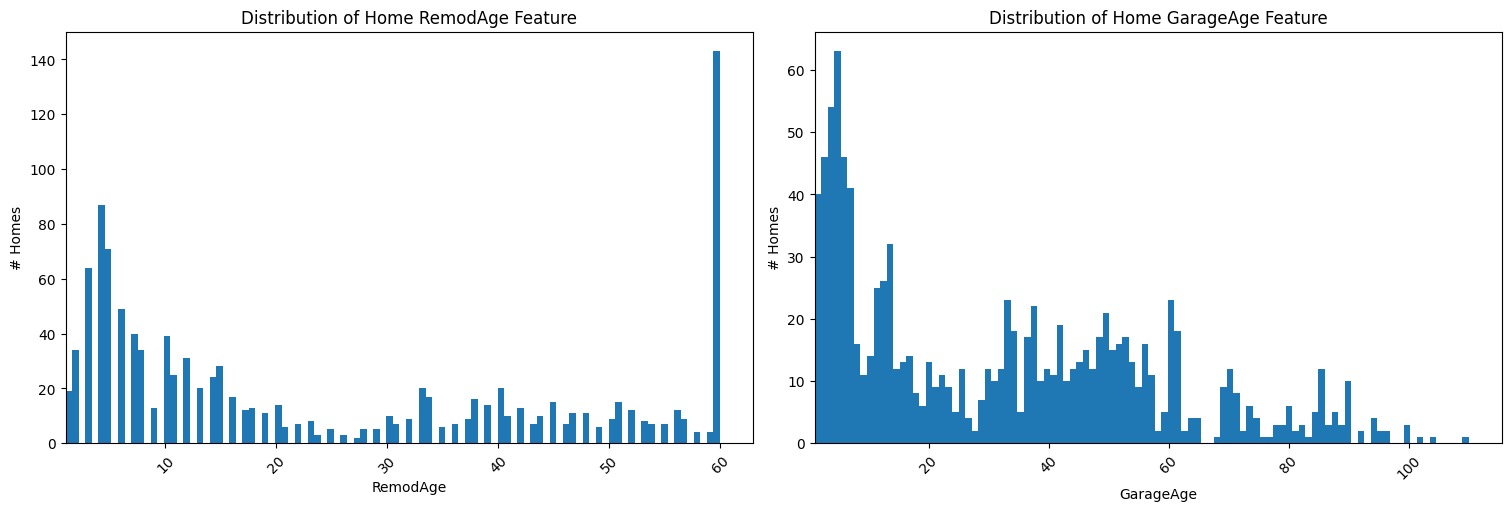

In [30]:
# Find out how many plots to make
num_plot = len(num_features)
num_col = 2
num_row = np.ceil(num_plot / num_col)
plot_col = 0

# If the last plot will not be a pair of plots,
extra_plot = False
if num_plot != num_col * num_row:
    extra_plot = True

# For all numeric columns
for col in num_features:
    # For the purpose of plotting filter out any zeros that might have been added.
    plot_df = df[df[col] > 0][col]

    # If this is the left-hand plot,
    if plot_col == 0:
        fig, axs = plt.subplots(1, num_col, figsize=(15, 5), constrained_layout=True) # Create a new figure for each 2 plots

    # Create the current sub-plot.
    axs[plot_col].hist(plot_df, bins=100)
    axs[plot_col].ticklabel_format(axis='y', useLocale=True)    
    axs[plot_col].set_title(f'Distribution of Home {col} Feature')
    axs[plot_col].set_xlabel(col)
    axs[plot_col].set_ylabel('# Homes')
    axs[plot_col].tick_params(axis='x', labelrotation=45) # Rotate x-axis labels for readability
    axs[plot_col].set_xlim(left=1)

    # Advance to the next plot.
    plot_col += 1
    if plot_col == num_col:
        plot_col = 0
        # Save and show the plot.
        plt.savefig(f'images/{col} Distribution.jpg')
        plt.show();

# If there is an extra plot,
if extra_plot == True:
    # Make the last plot not visible.
    axs[plot_col].set_visible(False)
    # Save and show the last plot plot.
    plt.savefig(f'images/{col} Distribution.jpg')
    plt.show();


MSSubClass should be treated as categorical data even though it is provided as numerical data.  The following is the interpretation:
- 20: 1-STORY 1946 & Newer AllStyles
- 30: 1-STORY 1945 & Older
- 40: 1-STORY w/Finished Attic All Ages
- 45: 1-1/2 STORY - Unfinished All Ages
- 50: 1-1/2 STORY Finished All Ages
- 60: 2-STORY 1946 & Newer
- 70: 2-STORY 1945 & Older
- 75: 2-1/2 STORY All Ages
- 80: SPLIT OR MULTI-LEVEL
- 85: SPLIT FOYER
- 90: DUPLEX - All Styles and Ages
- 120: 1-STORY PUD (Planned Unit Development) - 1946 & Newer
- 150: 1-1/2 STORY PUD - All Ages
- 160: 2-STORY PUD - 1946 & Newer
- 180: PUD - MULTILEVEL - Split Level
- 190: 2 FAMILY CONVERSION - All Styles and Ages

Because there are not many homes with 2 BsmtFullBath, BsmtHalfBath, or HalfBaths we should change these to boolean values indicating Have<X>Bath.
In other words, we should treat multiples of these bathrooms the same as having one of the indicated type. 

In [31]:
# Convert the following values to boolean values.
df['LowQualFin'] = df['LowQualFinSF'].astype(bool)
df.drop('LowQualFinSF', axis=1, inplace=True)
df['BsmtFullBath'] = df['BsmtFullBath'].astype(bool)
df['BsmtHalfBath'] = df['BsmtHalfBath'].astype(bool)
df['HalfBath']     = df['HalfBath'].astype(bool)
df['KitchenAbvGr'] = df['KitchenAbvGr'].astype(bool)
df['3SsnPorch']    = df['3SsnPorch'].astype(bool)
df['ScreenPorch']  = df['ScreenPorch'].astype(bool)


#### Eliminate Outliers

Rather than dropping these values and reducting the size of the dataset, we can set them to NA now so they will not impact our correlations.

In [32]:
def NAValuesAbove(df, col, max_limit):
    df.loc[df[col] > max_limit, col] = np.nan
    return

In [33]:
# Set outliers above limit to 0.
NAValuesAbove(df, 'LotFrontage', 125)
NAValuesAbove(df, 'LotArea', 20000)
NAValuesAbove(df, 'MasVnrArea', 700)
NAValuesAbove(df, 'TotalBsmtSF', 2500)
NAValuesAbove(df, '1stFlrSF', 2500)
NAValuesAbove(df, 'GrLivArea', 3000)
NAValuesAbove(df, 'GarageArea', 1000)
NAValuesAbove(df, 'WoodDeckSF', 500)
NAValuesAbove(df, 'OpenPorchSF', 300)
NAValuesAbove(df, 'EnclosedPorch', 300)
NAValuesAbove(df, 'RemodAge', 58)
NAValuesAbove(df, 'GarageAge', 250)


### Bivariate Analysis

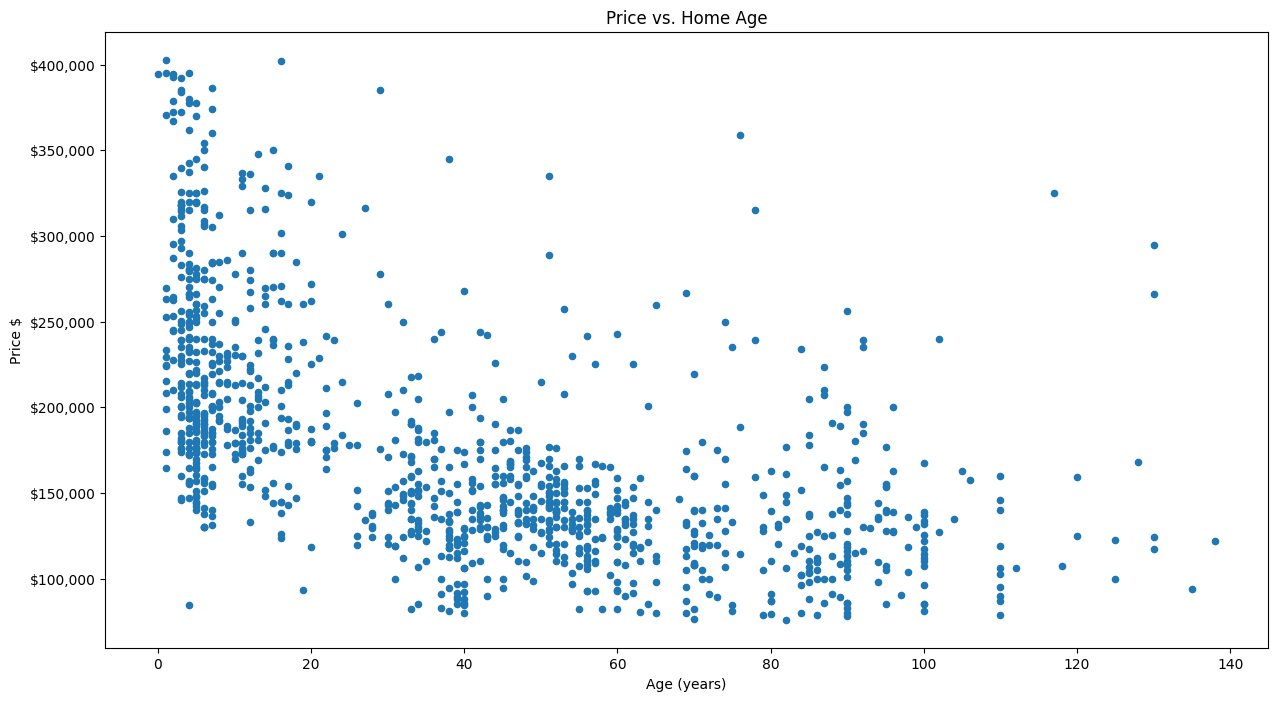

In [34]:
# Examine age versus price.
axes = df.plot(x='Age', y='SalePrice', kind='scatter', figsize=(15,8));
axes.set_title('Price vs. Home Age');
axes.set_ylabel('Price $')
axes.set_xlabel('Age (years)');
axes.yaxis.set_major_formatter(usd_formatter)

The age versus price plot above looks like it could be a logarithmic relationship.  
However, it is difficult to tell, especially past 60 years.  
It looks like we could correct for the recent changes by either by taking a log of the price or by fitting an exponential.

Below is a plot of age versus log price.
From this, we can see that taking the logarithm of price did not correct for inflation over the 60 years.

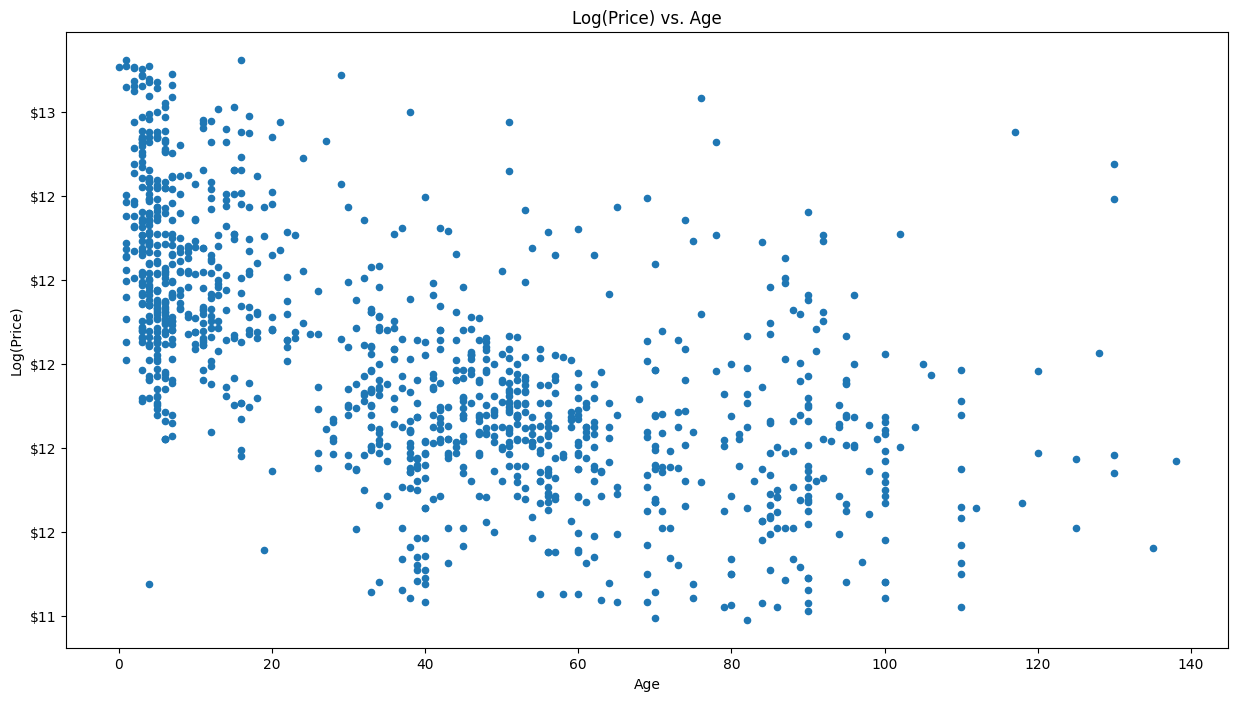

In [35]:
# Examine year versus LogPrice in the raw data.
df['LogPrice'] = np.log(df['SalePrice'])
axes = df.plot(x='Age', y='LogPrice', kind='scatter', figsize=(15,8)) #, ylim=(0, 100));
axes.set_title('Log(Price) vs. Age');
axes.set_ylabel('Log(Price)')
axes.set_xlabel('Age');
axes.yaxis.set_major_formatter(usd_formatter)
plt.savefig('images/LogPrice vs Age.jpg');

# Drop the log price column for now as we will not use it at this time.
df.drop('LogPrice', axis=1, inplace=True)

The relationship between price and home age appears to have shifted about 60 - 80 years ago.  
We might want to split the data into modern and historic homes.

In [36]:
# How many 70+ year old homes are there.
print(int(df[df['Age'] >= 70]['Age'].count()))

# 220 is a significant # of homes.  Maybe we only filter these out when looking at the impact of age.

220


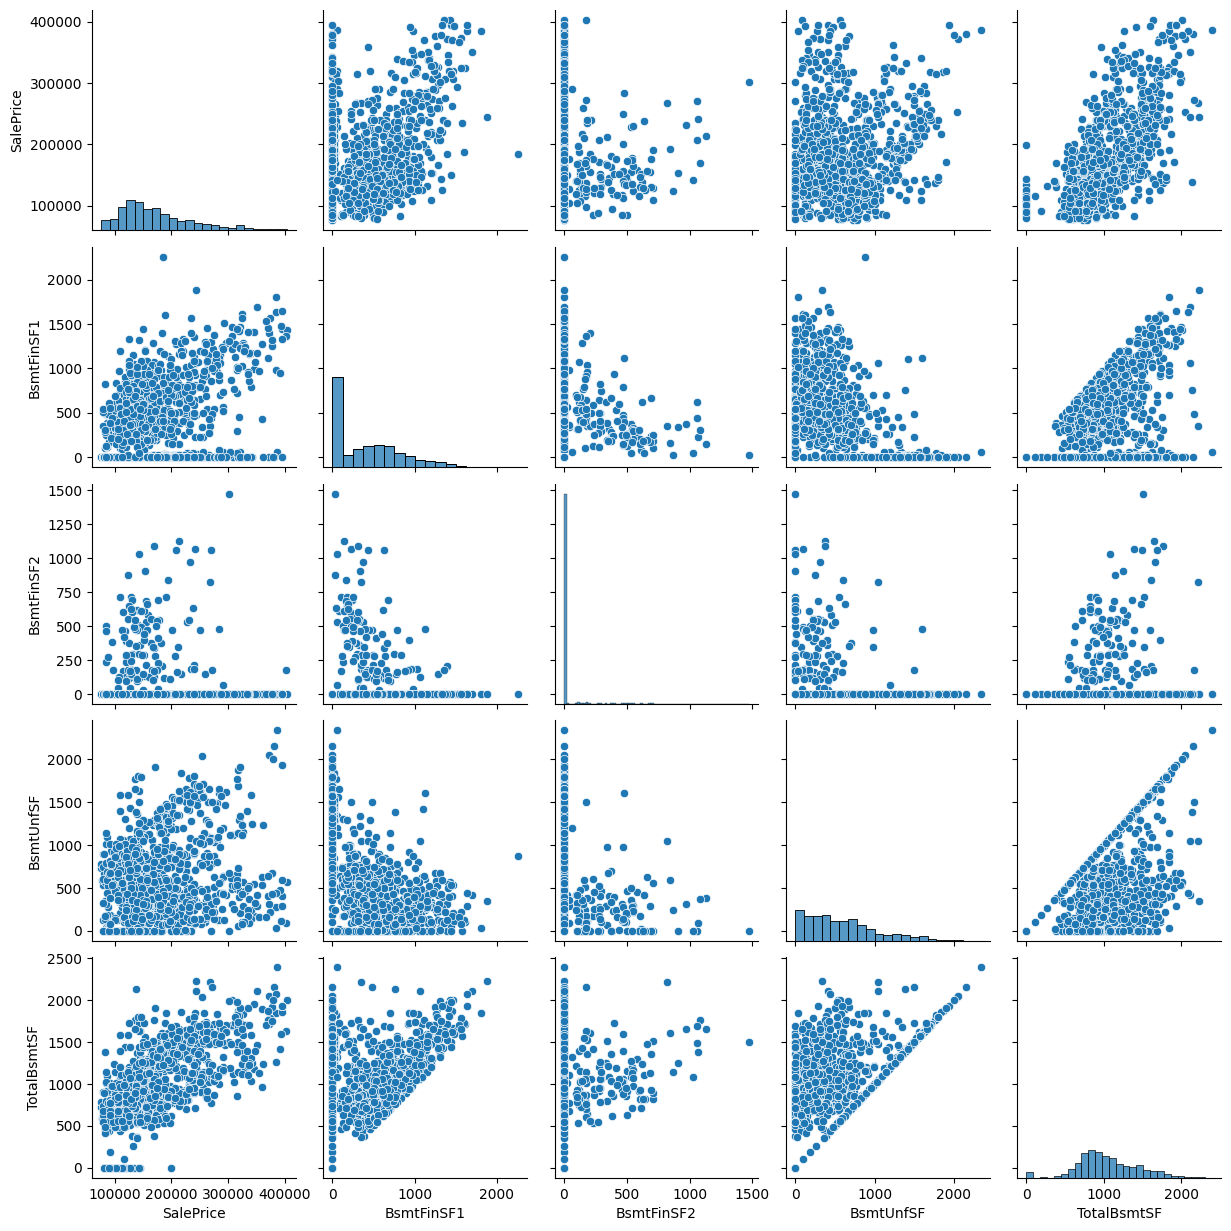

In [37]:
# Create a pairplot for all of the numeric basement features.
pair_df = df[['SalePrice', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]
pp = sns.pairplot(pair_df)
pp.savefig("images/BasementPairPlot.jpg")

The pairplots above would seem to indicate that the total basement square footage has the best correlation to sales price.
It should be the sum of the other 3 basement square footages.  Thus, it might be best to just use the TotalBsmtSF and drop the other basement SF features.

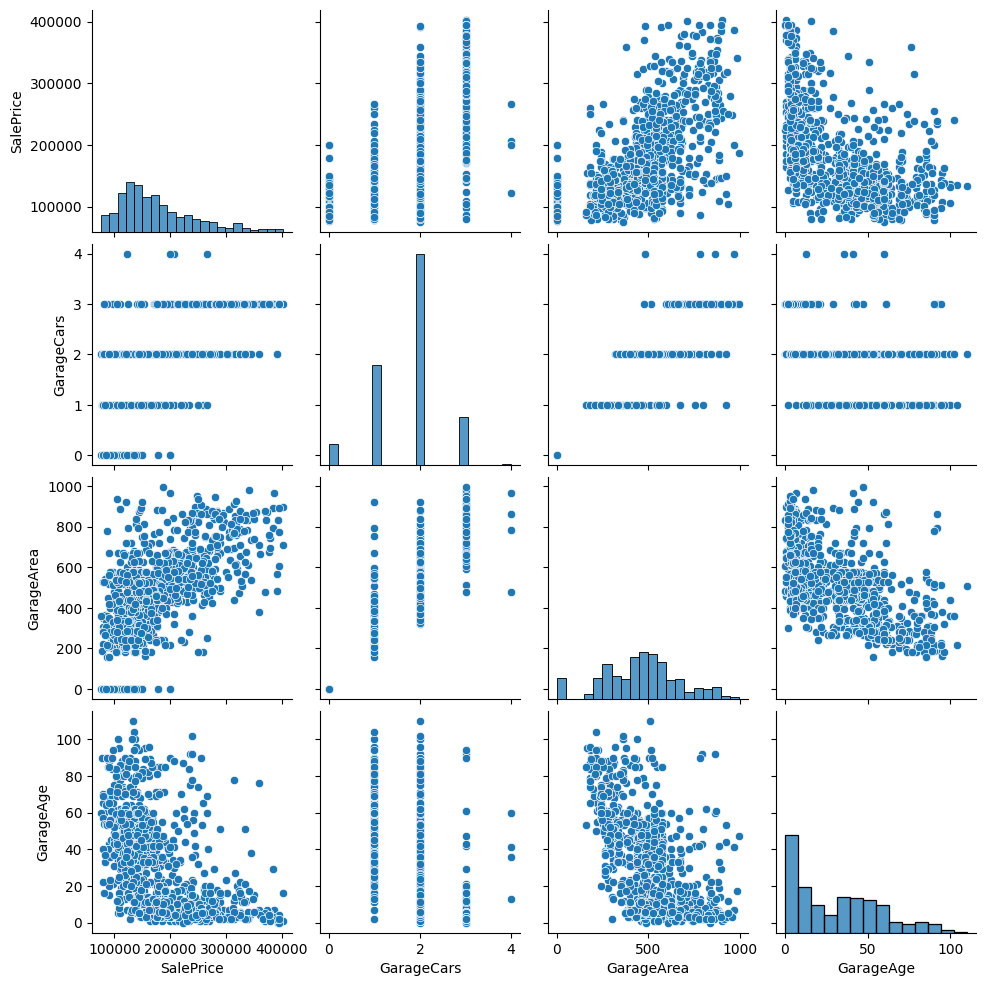

In [38]:
# Create a pairplot for all of the numeric garage features.
pair_df = df[['SalePrice', 'GarageCars', 'GarageArea', 'GarageAge']]
pp = sns.pairplot(pair_df)
pp.savefig("images/GaragePairPlot.jpg")

Price has a positive correlation to garage area and a negative correlation to Garage Age.  Thus, these seem to be important features to use in our model.  We have already seen a strong correlation to GarageCars and GarageArea.  So, it could be that we only need one of these for a simplified model.  

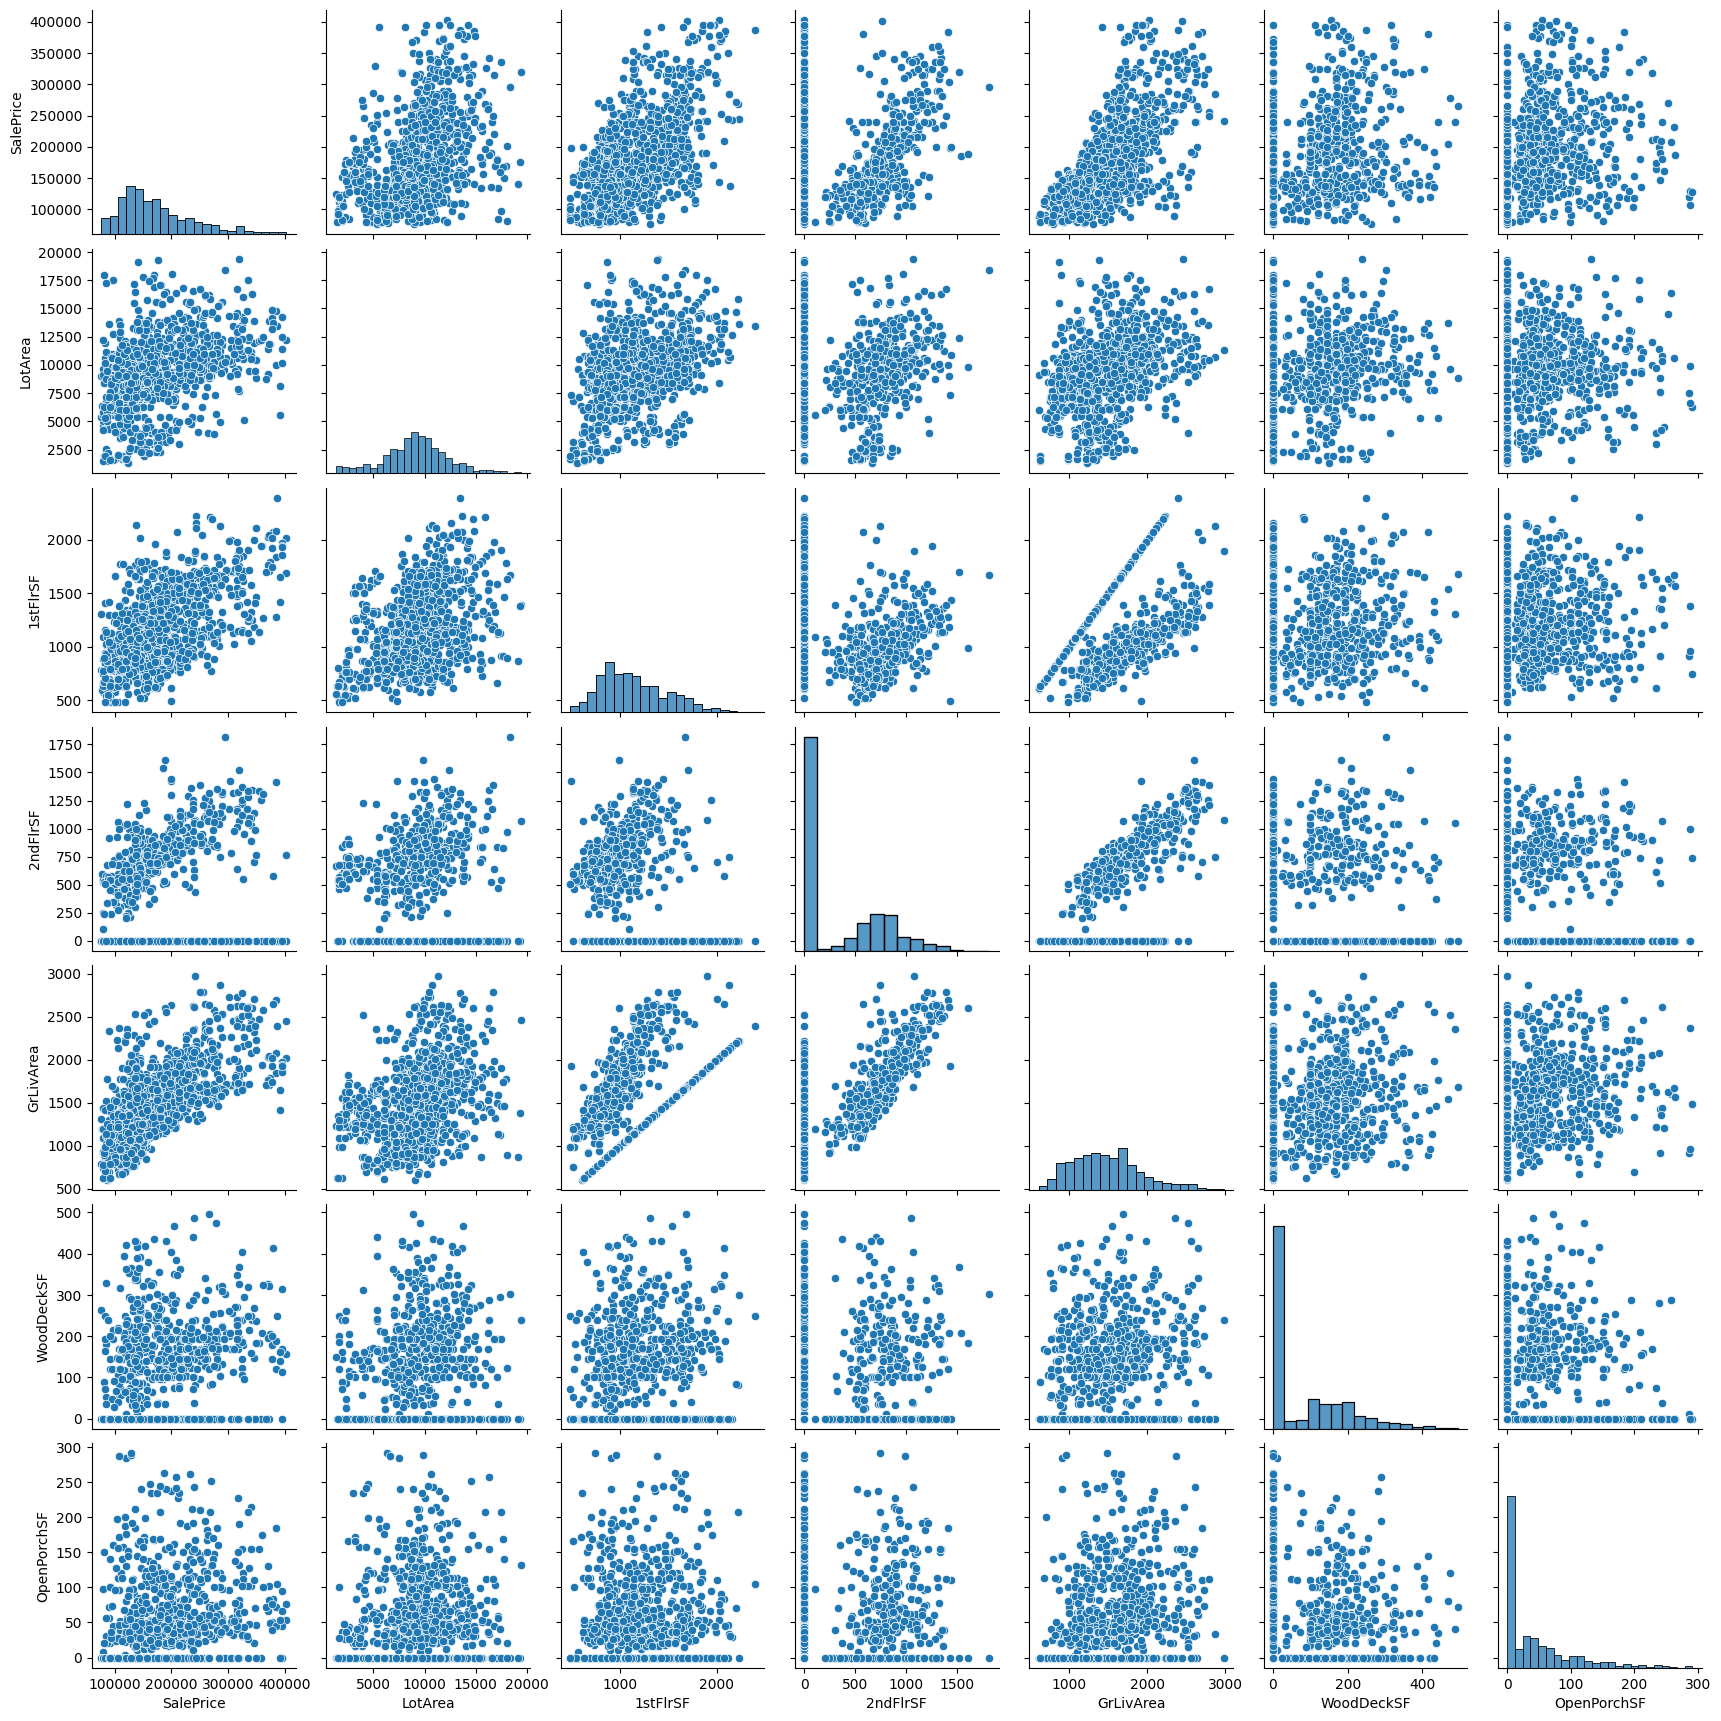

In [39]:
# Create a pairplot for all of the numeric square footage features.
pair_df = df[['SalePrice', 'LotArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']]
pp = sns.pairplot(pair_df)
pp.savefig("images/SFPairPlot.jpg")

The ground floor living area seems to correlate strongly to the 1st and 2nd floor square footages.  Thus, we may not need all 3 of these features.  We may just need the ground floor living area.

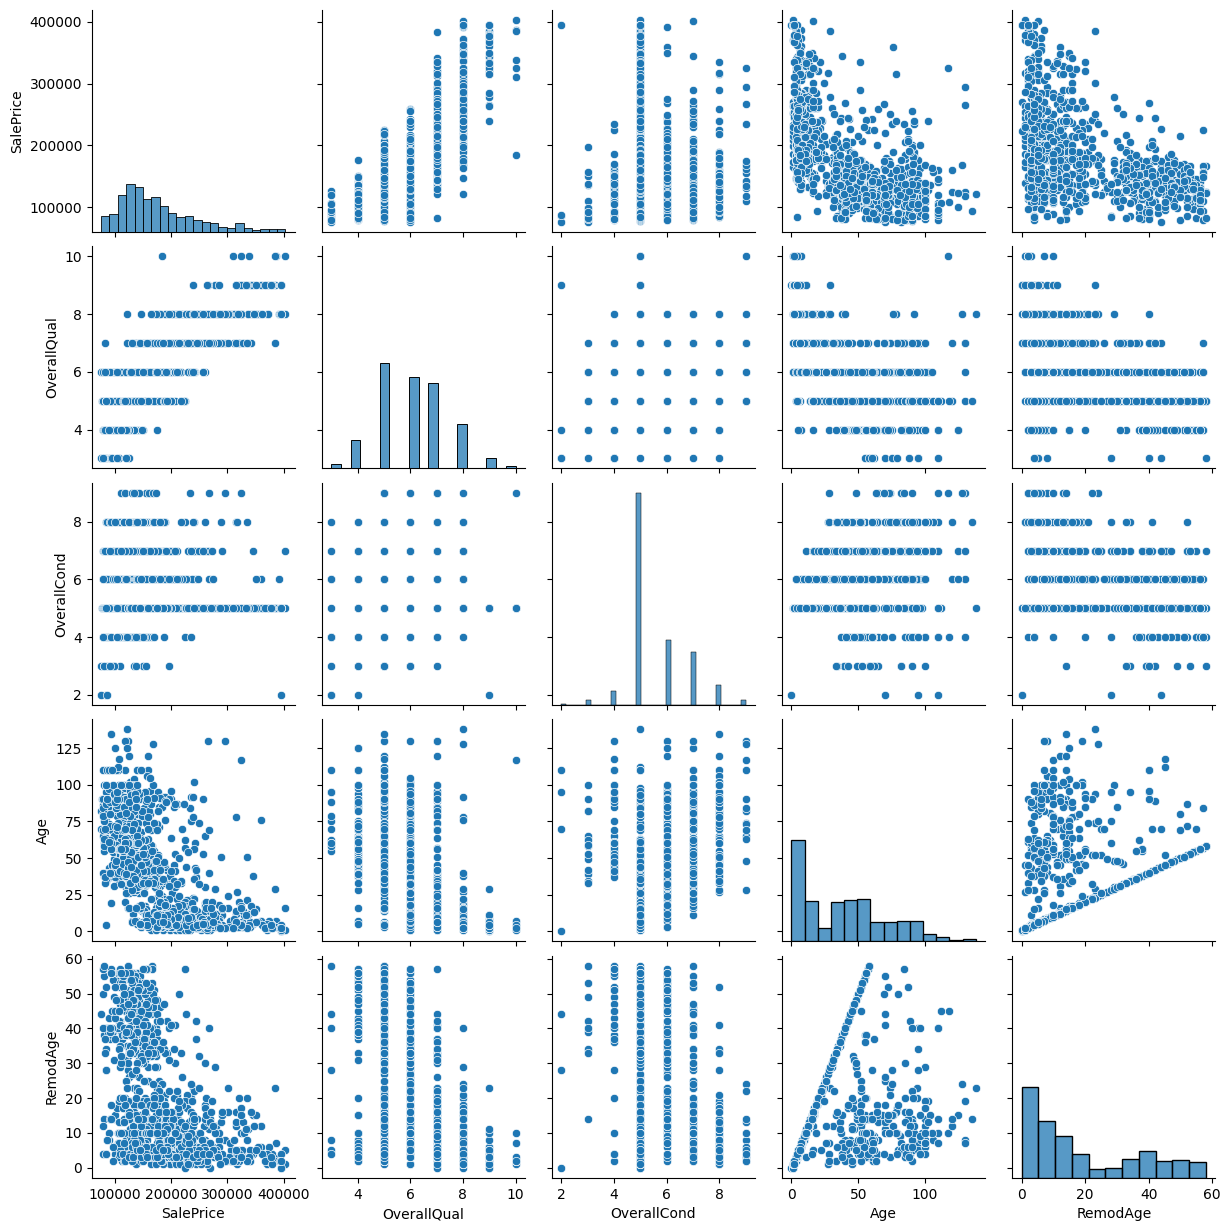

In [40]:
# Create a pairplot for all of the numeric condition and age features.
pair_df = df[['SalePrice', 'OverallQual', 'OverallCond', 'Age', 'RemodAge']]
pp = sns.pairplot(pair_df)
pp.savefig("images/QualityPairPlot.jpg")

With respect to the quality and age factors, it appears that the price correlates most strongly to the overall quality but that there is some inverse relationship to Age and RemodAge.  It could be that the quality is the only really important factor here.

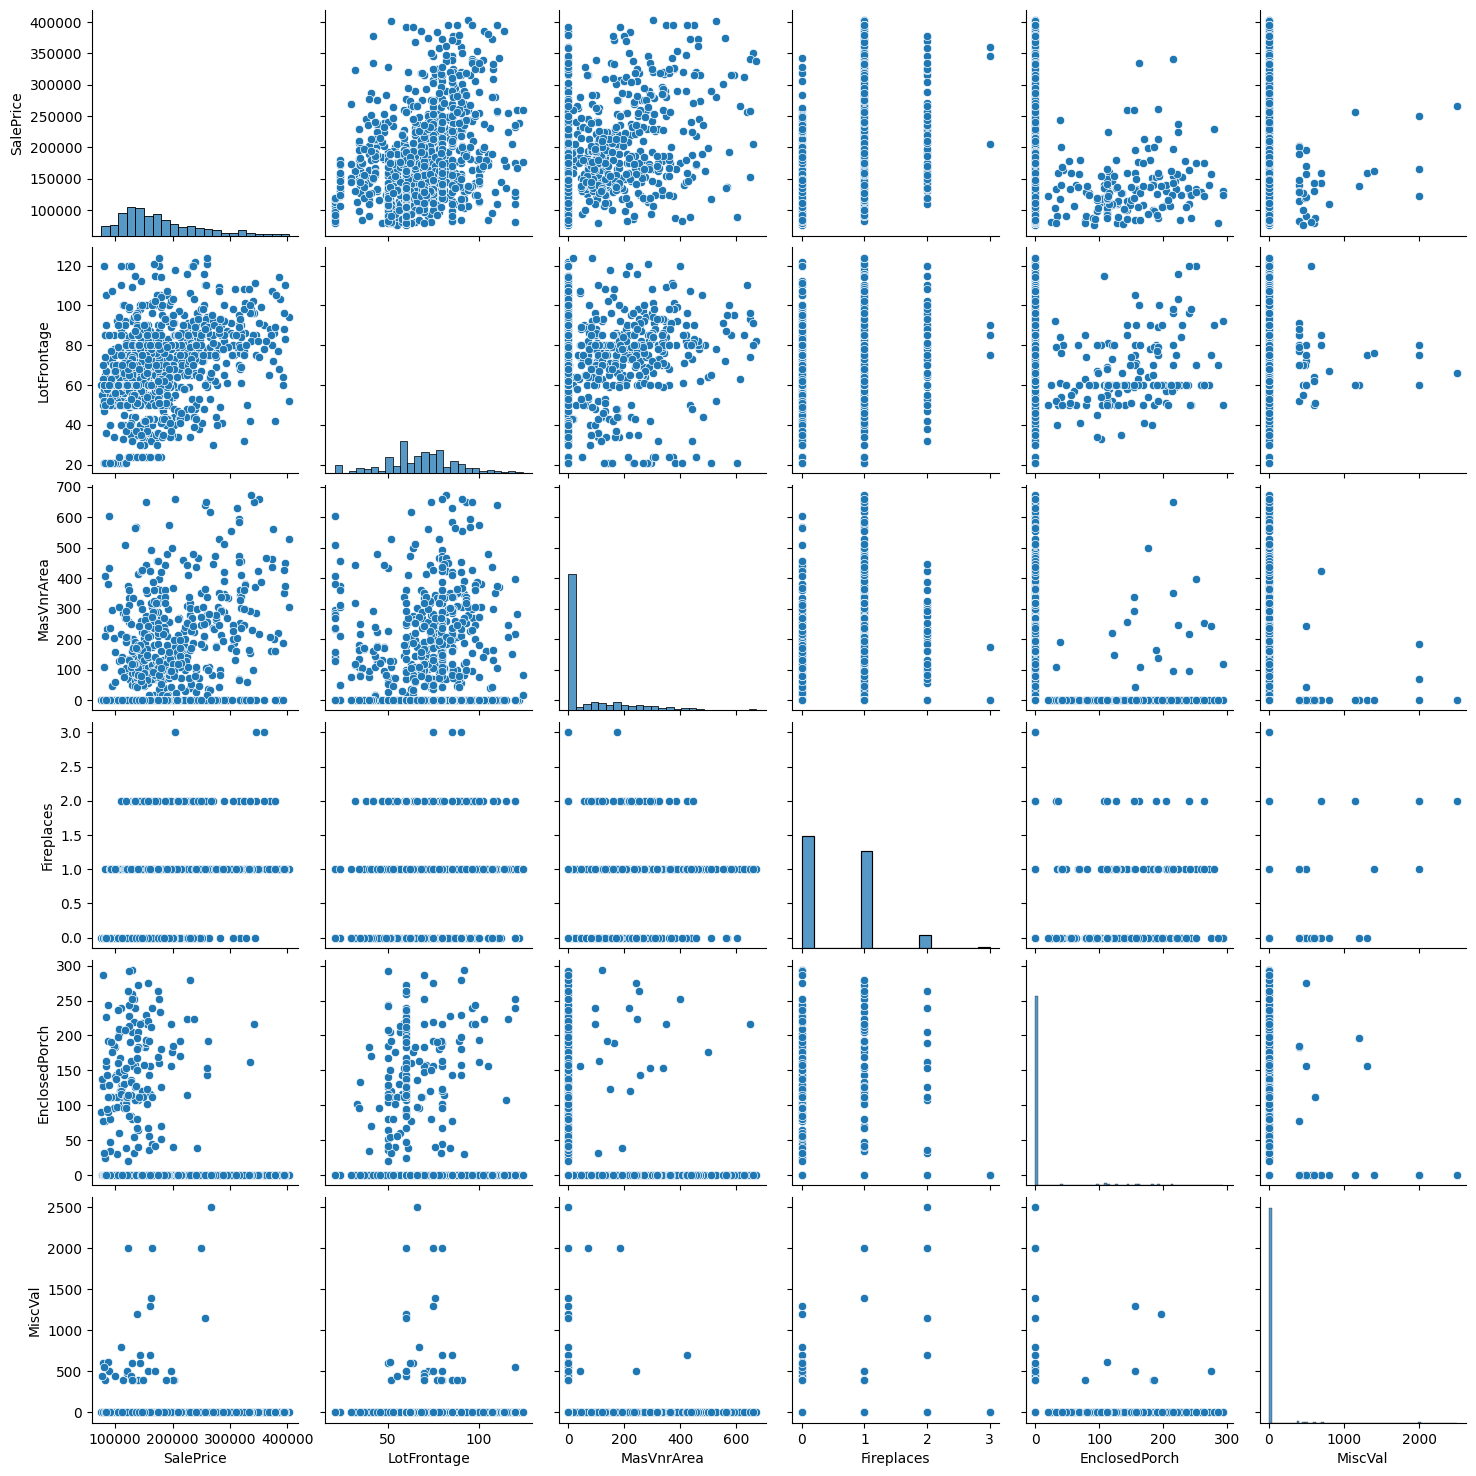

In [41]:
# Create a pairplot for some of the miscellaneous numeric features.
pair_df = df[['SalePrice', 'LotFrontage', 'MasVnrArea', 'Fireplaces', 'EnclosedPorch', 'MiscVal']]
pp = sns.pairplot(pair_df)
pp.savefig("images/OtherPairPlot.jpg")

Price doesn't appear to have a really strong correlation with any of these miscellaneous features.

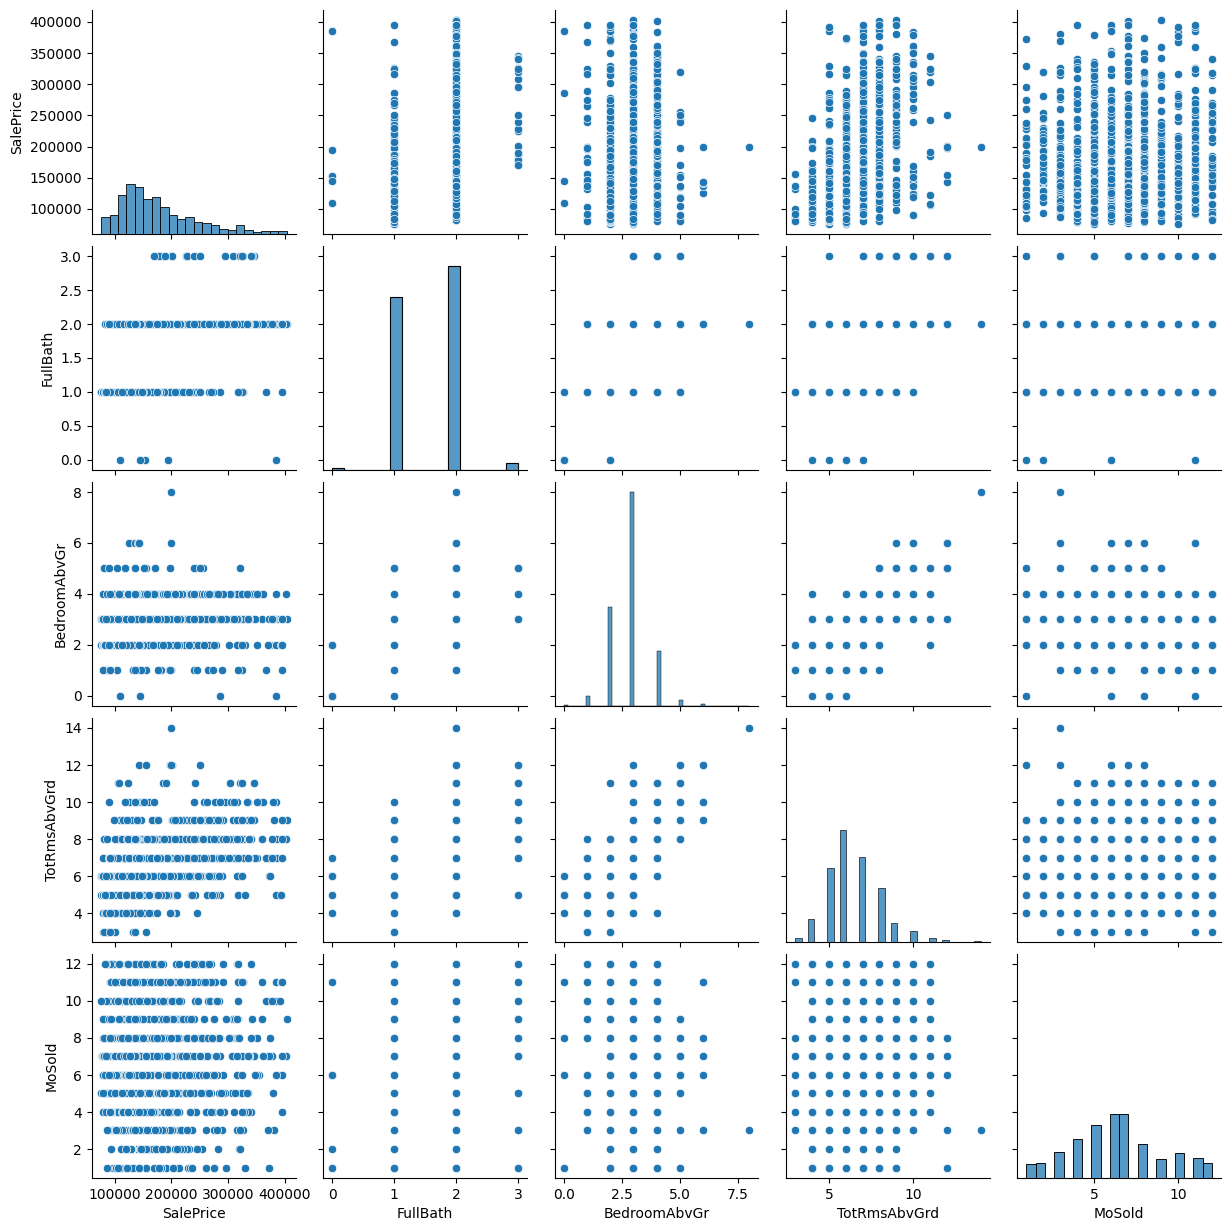

In [42]:
# Create a pairplot for the main room features and month sold.
pair_df = df[['SalePrice', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'MoSold']]
pp = sns.pairplot(pair_df)
pp.savefig("images/MainPairPlot.jpg")

A weak to moderate correlation between price and total rooms above ground is observable.  Also, total rooms above ground and bedrooms above ground seem to correlate well.  However, there doesn't appear to be too obvious a correlation between any of the other variables. 

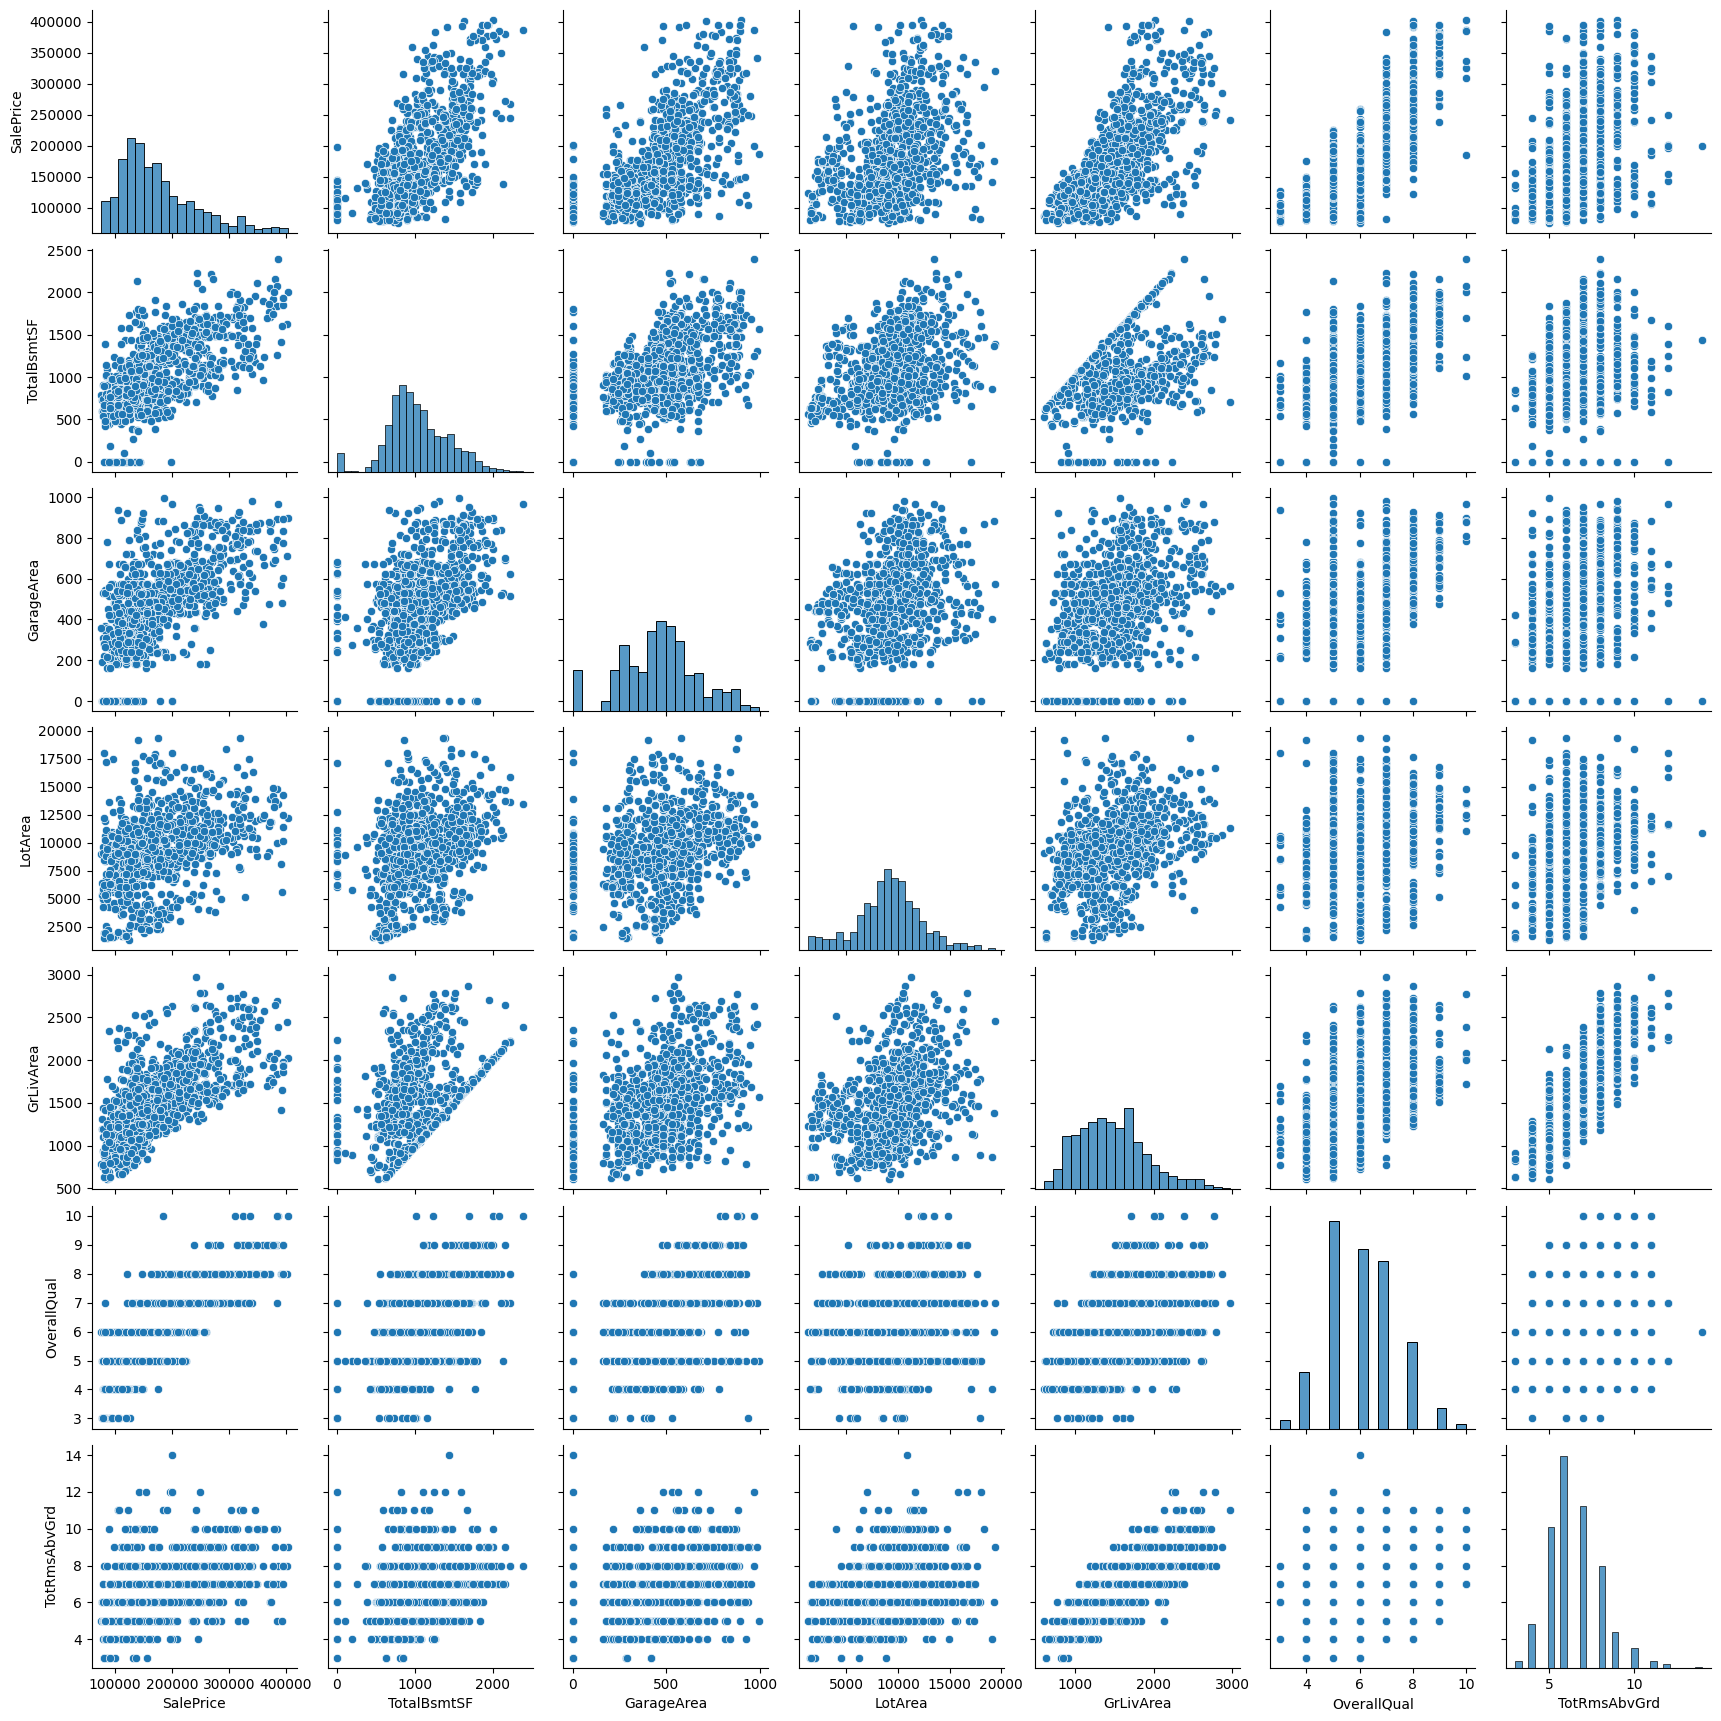

In [43]:
# This is our best-of pair plot
pair_df = df[['SalePrice', 'TotalBsmtSF', 'GarageArea', 'LotArea', 'GrLivArea', 'OverallQual', 'TotRmsAbvGrd']]
pp = sns.pairplot(pair_df)
pp.savefig("images/BestOfPairPlot.jpg")

From the pair plots, these features visually appear to have some of the best correlations with sale price and tend to be uncorrelated with each other.  The exception to this would the the strong correlation between Total rooms above ground and the ground floor living area.

In [44]:
# Define a funtion for getting a list of correlation coefficients for all numeric features in a dataframe.
def GetNumFeatCorrList(df):
    # Get the covariance matrix of all numeric features other than the sales price.
    # This will allow us to see if we should use PCA on some of the values to combine them.
    df_corr = df.corr(numeric_only=True)

    # Convert the matrix to a list and sort by descending correlation values.
    ltri_mask = np.tril(np.ones(df_corr.shape, dtype=bool), k=-1)
    tri_corr = df_corr.where(ltri_mask, 0)
    corr_list = tri_corr.stack().reset_index()
    corr_list.columns = ['feat1', 'feat2', 'corr']
    corr_list = corr_list[corr_list['corr'] != 0]

    # Create a sorted list of the correlation coefficient magnitudes.
    corr_list['mag_corr'] = corr_list['corr'].abs()
    corr_list.sort_values(by='mag_corr', ascending=False, inplace=True)

    return corr_list

In [45]:
# Move the SalePrice column to the end.
col_to_move = df.pop('SalePrice')
df['SalePrice'] = col_to_move

# Get a list of sorted correlation coefficients for the numeric features.
corr_list = GetNumFeatCorrList(df)

# Remove the SalesPrice from  all correlations
feat_corr = corr_list[(corr_list['feat1'] != 'SalePrice') & (corr_list['feat2'] != 'SalePrice')]

pd.set_option('display.max_rows', None)
print(feat_corr)


              feat1          feat2      corr  mag_corr
755      GarageArea     GarageCars  0.892927  0.892927
1148      GarageAge            Age  0.822835  0.822835
641    TotRmsAbvGrd      GrLivArea  0.814393  0.814393
323        1stFlrSF    TotalBsmtSF  0.795988  0.795988
35          LotArea    LotFrontage  0.696711  0.696711
646    TotRmsAbvGrd   BedroomAbvGr  0.678470  0.678470
395       GrLivArea       2ndFlrSF  0.674424  0.674424
425    BsmtFullBath     BsmtFinSF1  0.652363  0.652363
535        HalfBath       2ndFlrSF  0.608314  0.608314
640    TotRmsAbvGrd       2ndFlrSF  0.607181  0.607181
501        FullBath      GrLivArea  0.598764  0.598764
1139      GarageAge     GarageCars -0.584599  0.584599
1140      GarageAge     GarageArea -0.584325  0.584325
1017            Age    OverallQual -0.579141  0.579141
702      GarageCars    OverallQual  0.572326  0.572326
387       GrLivArea    OverallQual  0.555950  0.555950
1122      GarageAge    OverallQual -0.546593  0.546593
250       

From the correlations above, we might consider dropping the GarageCars column in lieu of the GarageArea or using PCA to combine them.
Also, we might drop the GarageAge in lieu of (Home) Age.
Likewise, we may not need GrLivArea and BedroomAbvGr if we keep TotRmsAbvGrd.

Let's look at what correlates highly to sales price first.

In [46]:
# Extract the correlations that only contain SalesPrice.
price_corr = corr_list[(corr_list['feat1'] == 'SalePrice') | (corr_list['feat2'] == 'SalePrice')]
print(price_corr)

          feat1          feat2      corr  mag_corr
1191  SalePrice    OverallQual  0.808451  0.808451
1200  SalePrice      GrLivArea  0.678756  0.678756
1209  SalePrice     GarageCars  0.645627  0.645627
1197  SalePrice    TotalBsmtSF  0.637914  0.637914
1210  SalePrice     GarageArea  0.632156  0.632156
1198  SalePrice       1stFlrSF  0.603027  0.603027
1218  SalePrice            Age -0.571188  0.571188
1203  SalePrice       FullBath  0.550418  0.550418
1221  SalePrice      GarageAge -0.526747  0.526747
1220  SalePrice       RemodAge -0.488074  0.488074
1207  SalePrice   TotRmsAbvGrd  0.462769  0.462769
1208  SalePrice     Fireplaces  0.459849  0.459849
1193  SalePrice     MasVnrArea  0.429711  0.429711
1190  SalePrice        LotArea  0.404864  0.404864
1194  SalePrice     BsmtFinSF1  0.366899  0.366899
1189  SalePrice    LotFrontage  0.360952  0.360952
1212  SalePrice    OpenPorchSF  0.352716  0.352716
1211  SalePrice     WoodDeckSF  0.339724  0.339724
1204  SalePrice       HalfBath 

It looks like SaleAge is the only column that doesn't have an impact upon sales price (other than potentially adjusting for inflation).

Of the values that we previously observed a high correlation, we should:
1. Keep GarageCars instead of GarageArea as it appears to be more highly correlated to price.
2. Drop GarageAge in lieu of Age due to their correlation with price.


In [47]:
# Drop the columns that either have very little correlation with price or those that are highly correlated with another feature.
df.drop(['SaleAge', 'GarageArea', 'GarageAge'], axis=1, inplace=True)

# Update the list of correlation coefficients.
# Get a list of sorted correlation coefficients for the numeric features.
corr_list = GetNumFeatCorrList(df)

# Extract the correlations that only contain SalesPrice.
price_corr = corr_list[(corr_list['feat1'] == 'SalePrice') | (corr_list['feat2'] == 'SalePrice')]
print(price_corr)

# Extract the feature column names in order of correlation strength.
feat_order = price_corr['feat2']

          feat1          feat2      corr  mag_corr
994   SalePrice    OverallQual  0.808451  0.808451
1003  SalePrice      GrLivArea  0.678756  0.678756
1012  SalePrice     GarageCars  0.645627  0.645627
1000  SalePrice    TotalBsmtSF  0.637914  0.637914
1001  SalePrice       1stFlrSF  0.603027  0.603027
1020  SalePrice            Age -0.571188  0.571188
1006  SalePrice       FullBath  0.550418  0.550418
1021  SalePrice       RemodAge -0.488074  0.488074
1010  SalePrice   TotRmsAbvGrd  0.462769  0.462769
1011  SalePrice     Fireplaces  0.459849  0.459849
996   SalePrice     MasVnrArea  0.429711  0.429711
993   SalePrice        LotArea  0.404864  0.404864
997   SalePrice     BsmtFinSF1  0.366899  0.366899
992   SalePrice    LotFrontage  0.360952  0.360952
1014  SalePrice    OpenPorchSF  0.352716  0.352716
1013  SalePrice     WoodDeckSF  0.339724  0.339724
1007  SalePrice       HalfBath  0.271872  0.271872
1002  SalePrice       2ndFlrSF  0.245246  0.245246
1004  SalePrice   BsmtFullBath 

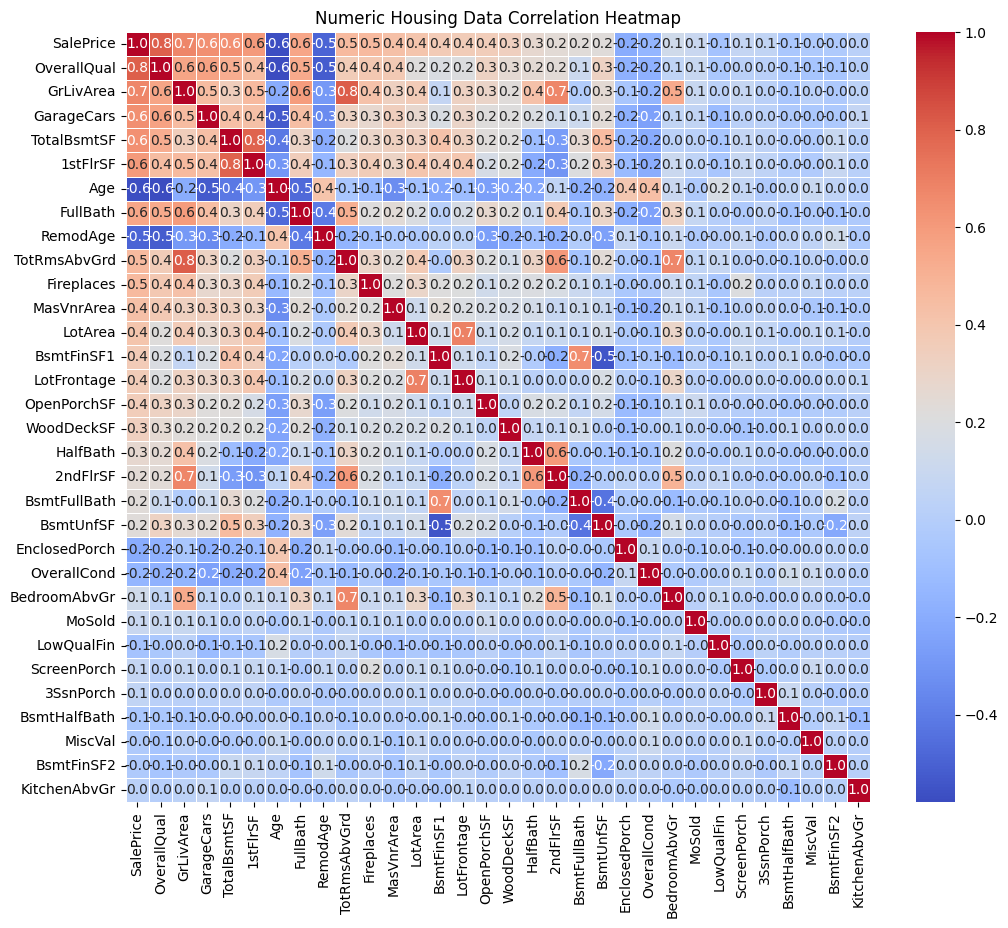

<Figure size 640x480 with 0 Axes>

In [48]:
feat_order = price_corr['feat2'].to_list()
feat_order.insert(0, 'SalePrice')

# Compute the correlation of the numeric features.
ndf = df[feat_order]
ndf_corr = ndf.corr()

# Generate a heatmap of numeric feature correlations.
plt.figure(figsize=(12, 10)) 
sns.heatmap(ndf_corr, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5)
plt.title('Numeric Housing Data Correlation Heatmap')
plt.show()
plt.savefig('images/Numeric Corr Heatmap.jpg');


#### Most Significant Numeric Features
Most of the correlations listed above make intuitive sense.  <br> 
The house quality, above-ground square footage, garage size, basement size, 1st floor size, and house newness have the most impact upon sales price.  <br>
There are a few surprises:  Enclosed Porch, Kitchen Above Ground, Overall Condition, and Low Quality Finish Square Footage have a negative impact upon the price.  <br><br>

This data indicate that an enclosed porch has a negative impact upon value and yet the porch square footage has a positive correlation.  Thus if a property has an enclosed porch, there might be some value to tearing down the walls.  This is especially true if the porch walls are not in good shape.  <br><br>

Total rooms above ground has a strong correlation to price.  Since having a kitchen above ground has a negative correlation to price, there might be a benefit to remodel to move an upstairs kitchen to the ground floor.  However, it is worthwhile to note that there is more value to be had if the property is in poor condition.  Otherwise, one might not get a return on the investment. <br><br>

The negative correlation of month sold to price is probably an artifact of this feature being handled as a numeric value, e.g. month of year.  We should convert this to a categorical value, because we do not expect a simple correlation between these two values.  The spring and summer months should have the highest demand and thus the highest prices.  Therefore, we should convert this to a categorical feature using the month names.  <br><br>

Because the low quality finish square footage has a negative impact upon price, it may make sense to replace some low quality fixtures with something cheap but mid quality from Contractor's Wherehouse or Home Depot.  Some cheap but quick fixes like painting also might make sense. <br><br>

We will convert the sales month feature in a future revision of this work.

## Data Preparation
Goals:
* Feature Selection
* Feature Engineering
* Standard Scaler for numerical values
* One Hot Encoding for categorical values

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### Data Transformation


In [49]:
# First, let's make a copy of the dataframe
data = df.copy(deep=True)

# Now we should fill all NAs in the numeric colums with zero.
data.update(df.select_dtypes(include=np.number).fillna(0))

# Perform any extra data transformations here if required, e.g. PCA.


In [50]:
# Separate the data to inputs and output columns.  Also, update the list of object columns.
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']
print(data.shape)
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.to_list()

# Create test / train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # Include stratify=X[] if there are some rare categories.

# Scale data with StandardScaler() from sklearn (use fit and transform methods) before using either Lasso or Ridge.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
scale = StandardScaler()
X_train_scaled[num_cols] = scale.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scale.transform(X_test[num_cols])


(1148, 68)


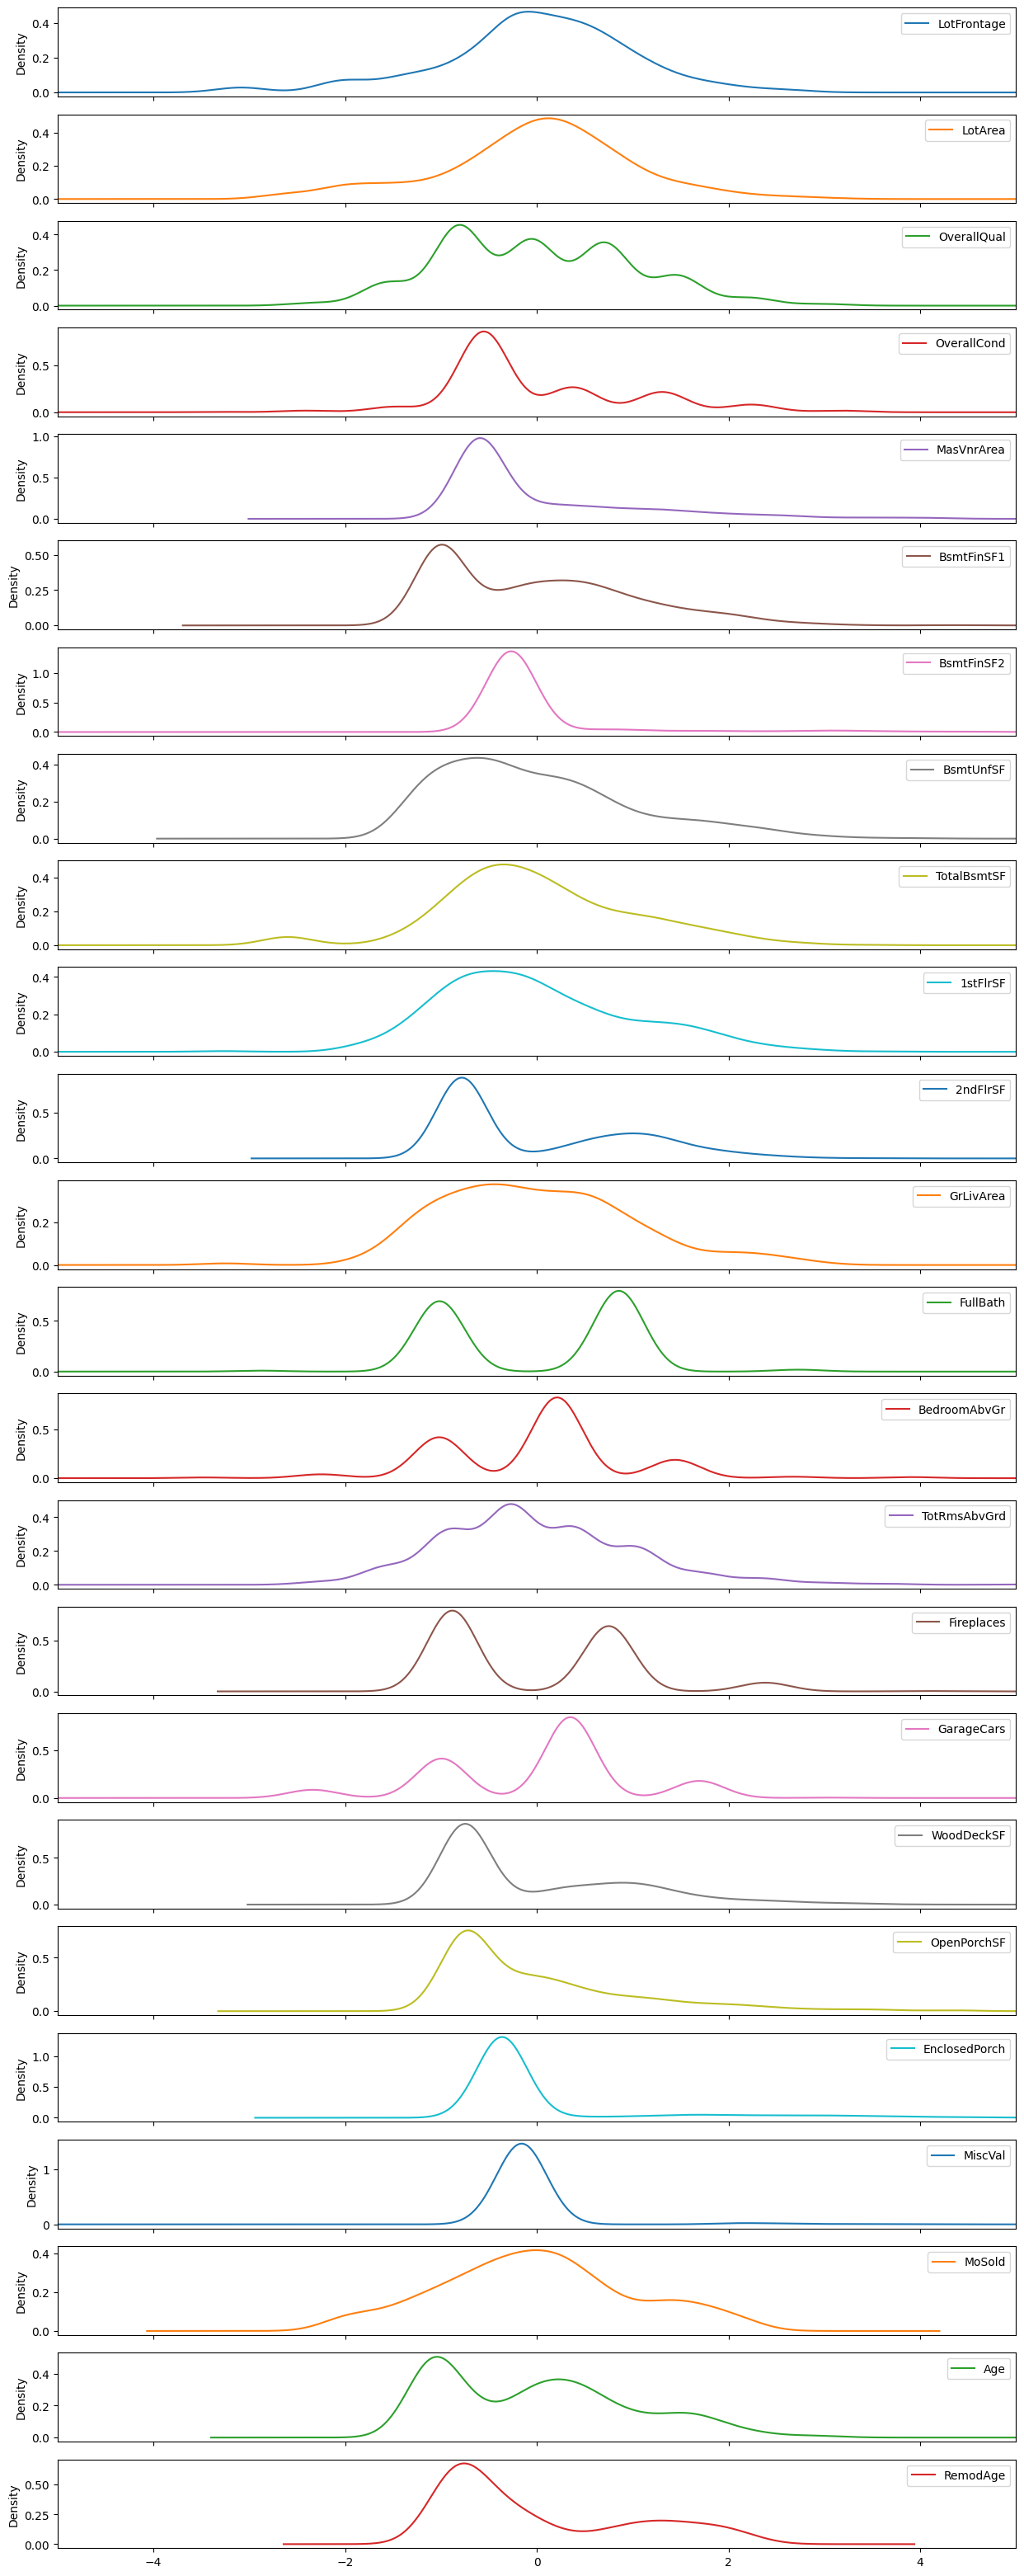

In [51]:

# Plot the scaled numeric data.
axes = X_train_scaled.plot(kind='kde', subplots=True, figsize=(15,40), xlim=(-5,5))


## Modeling

With our final dataset, we should build a baseline model.  <br> 
Eventually, we will build a number of different  models with the SalePrice as the target.  <br>

In [52]:
# Create an array of column transformers for each data type.
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  StandardScaler(), num_cols),
        ('cat',  OneHotEncoder(), cat_cols)
    ], remainder='passthrough'
)

# Create a pipeline
lr_pipe = Pipeline([
    ('preproc', preprocessor),
    ('linreg', LinearRegression())
])


### Baseline Model 
We will first look at baseline models using just numeric data and all data.

In [53]:
def FitAndTestLinearModel(X_train, X_test, y_train, y_test):
    # Update the column list.
    cat_cols = X_train.select_dtypes(include='object').columns.tolist()
    num_cols = X_train.select_dtypes(include=np.number).columns.to_list()

    # Create an array of column transformers for each data type.
    preproc = ColumnTransformer(
        transformers=[
            ('num',  StandardScaler(), num_cols),
            ('cat',  OneHotEncoder(), cat_cols)
        ], remainder='passthrough'
    )

    # Create a pipeline
    lr_pipe = Pipeline([
        ('preproc', preproc),
        ('linreg', LinearRegression())
    ])

    # Fit the LinearRegression
    linear_model = lr_pipe.fit(X_train, y_train)

    # Create predictions
    y_train_pred = linear_model.predict(X_train)
    y_test_pred = linear_model.predict(X_test)

    # Compute RMSE
    train_rmse = np.round(root_mean_squared_error(y_train, y_train_pred),0)
    test_rmse = np.round(root_mean_squared_error(y_test, y_test_pred),0)

    # Get the coefficients
    lin_coef = np.round(linear_model.named_steps['linreg'].coef_)
    feature_names = linear_model.named_steps['preproc'].get_feature_names_out()
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lin_coef})
    coef_df.sort_values(by='Coefficient', ascending=False, inplace=True)

    # Return the results
    return train_rmse, test_rmse, coef_df


In [54]:
# We have already grabbed the column names for each type of data.  (num_cols & cat_cols)
# Let's look at a model that just uses the numeric columns.
X_train_num = X_train[num_cols].copy()
X_test_num = X_test[num_cols].copy()

# Train and test a linear model with just the numeric columns.
train_rmse, test_rmse, coef_df = FitAndTestLinearModel(X_train_num, X_test_num, y_train, y_test)

# Print the results
data = [['Linear', train_rmse, test_rmse]]
columns = ['Model', 'Train RMSE', 'Test RMSE']
comparison = pd.DataFrame(data=data, columns=columns)
print(comparison)
print()
print(coef_df)


    Model  Train RMSE  Test RMSE
0  Linear     23525.0    28017.0

               Feature  Coefficient
2     num__OverallQual      18787.0
10       num__2ndFlrSF      15966.0
9        num__1stFlrSF      15849.0
5      num__BsmtFinSF1      14472.0
3     num__OverallCond       6858.0
16     num__GarageCars       5828.0
11      num__GrLivArea       5616.0
7       num__BsmtUnfSF       5316.0
0     num__LotFrontage       4148.0
18    num__OpenPorchSF       3555.0
15     num__Fireplaces       3465.0
8     num__TotalBsmtSF       3440.0
1         num__LotArea       3149.0
17     num__WoodDeckSF       2825.0
6      num__BsmtFinSF2       2750.0
4      num__MasVnrArea       2041.0
19  num__EnclosedPorch        658.0
21         num__MoSold        502.0
20        num__MiscVal        -22.0
12       num__FullBath       -562.0
14   num__TotRmsAbvGrd       -928.0
13   num__BedroomAbvGr      -4510.0
23       num__RemodAge      -4946.0
22            num__Age     -13114.0


These results appear to confirm our earlier suggestion that kitchens above ground have a negative impact upon the sales price.  <br><br>  

However, this model also seems to indicate that bedrooms above ground have a negative impact.  However, this may need to be combined with positive correlation with the square footage above ground or with the total number of rooms.  In other words, having more bedrooms or rooms in the house is an asset.  However, if those rooms are on a higher floor, they may have less value than if they are on the ground (i.e. 1st) floor.


In [55]:
# Train and test a linear model with all columns, numeric and categorical.
train_rmse, test_rmse, coef_df = FitAndTestLinearModel(X_train, X_test, y_train, y_test)

# Print the results
data = [['Linear', train_rmse, test_rmse]]
columns = ['Model', 'Train RMSE', 'Test RMSE']
comparison = pd.DataFrame(data=data, columns=columns)
print(comparison)
print()
print(coef_df)


    Model  Train RMSE  Test RMSE
0  Linear     18794.0    26411.0

                         Feature  Coefficient
10                 num__2ndFlrSF      15409.0
78              cat__BsmtQual_Ex      13330.0
9                  num__1stFlrSF      13055.0
2               num__OverallQual      12734.0
116      cat__GarageFinish_Other      12482.0
5                num__BsmtFinSF1      12342.0
34           cat__LotShape_Other      11880.0
55      cat__Exterior1st_MetalSd       8939.0
11                num__GrLivArea       8432.0
69          cat__ExterQual_Other       8229.0
107          cat__Functional_Typ       6793.0
72          cat__ExterCond_Other       6722.0
140        remainder__LowQualFin       6623.0
49            cat__BldgType_1Fam       6614.0
100            cat__CentralAir_Y       6395.0
3               num__OverallCond       6333.0
104       cat__KitchenQual_Other       6051.0
16               num__GarageCars       5200.0
8               num__TotalBsmtSF       5184.0
28           

It is interesting to note that while the Train RMSE improved significantly ($23.5k -> $18.8k), the Test RMSE only improved slightly ($28.0k -> $26.4)

We could consider dropping some of the less important features and see what impact this has on the Test RMSE.
E.G. MiscVal, 3SsnPorrch, LandSlope, PavedDrive, ScreenPorch, Electrical, EnclosedPorch, BsmtCond

With this model, we see a negative value for averge (ALQ) basement finish type and a positive value for a good finish (GLQ).  Ergo, it may be worthwhile to consider a quick beautification of the basement before sale.  <br><br>

Because there is such a high negative correlation ~$8.4k with having a basement half bath and only an ~$3.4k value to having this as an extra half bath, one might consider removing this half bath ... as long as tearing it out doesn't cost more than $5k.  In other words, this might only make sense for an owner to do and not an investor. <br><br>


In [56]:
# Drop the aforementioned columns.
cols_to_drop = ['MiscVal', '3SsnPorch', 'LandSlope', 'PavedDrive', 'ScreenPorch', 'Electrical', 'EnclosedPorch', 'BsmtCond']
W_train = X_train.drop(cols_to_drop, axis=1).copy(deep=True)
W_test = X_test.drop(cols_to_drop, axis=1).copy(deep=True)

# Train and test a linear model with just the numeric columns.
train_rmse, test_rmse, coef_df = FitAndTestLinearModel(W_train, W_test, y_train, y_test)

# Print the results
data = [['Linear', train_rmse, test_rmse]]
columns = ['Model', 'Train RMSE', 'Test RMSE']
comparison = pd.DataFrame(data=data, columns=columns)
print(comparison)
print()
print(coef_df)


    Model  Train RMSE  Test RMSE
0  Linear     18813.0    26403.0

                         Feature  Coefficient
10                 num__2ndFlrSF      15344.0
74              cat__BsmtQual_Ex      13238.0
9                  num__1stFlrSF      13218.0
2               num__OverallQual      12650.0
5                num__BsmtFinSF1      12239.0
108      cat__GarageFinish_Other      12178.0
32           cat__LotShape_Other      12084.0
51      cat__Exterior1st_MetalSd       9098.0
11                num__GrLivArea       8587.0
65          cat__ExterQual_Other       8431.0
45            cat__BldgType_1Fam       6741.0
99           cat__Functional_Typ       6711.0
94             cat__CentralAir_Y       6606.0
128        remainder__LowQualFin       6471.0
68          cat__ExterCond_Other       6430.0
3               num__OverallCond       6310.0
96        cat__KitchenQual_Other       6045.0
16               num__GarageCars       5253.0
26           cat__MSZoning_Other       5130.0
8            

Dropping these columns had very little impact upon either the Train or Test RMSE, Train: $18.8k and Test: $26.4k. <br>
This might be better simply because it is a simplier model and less likely to be overfit.

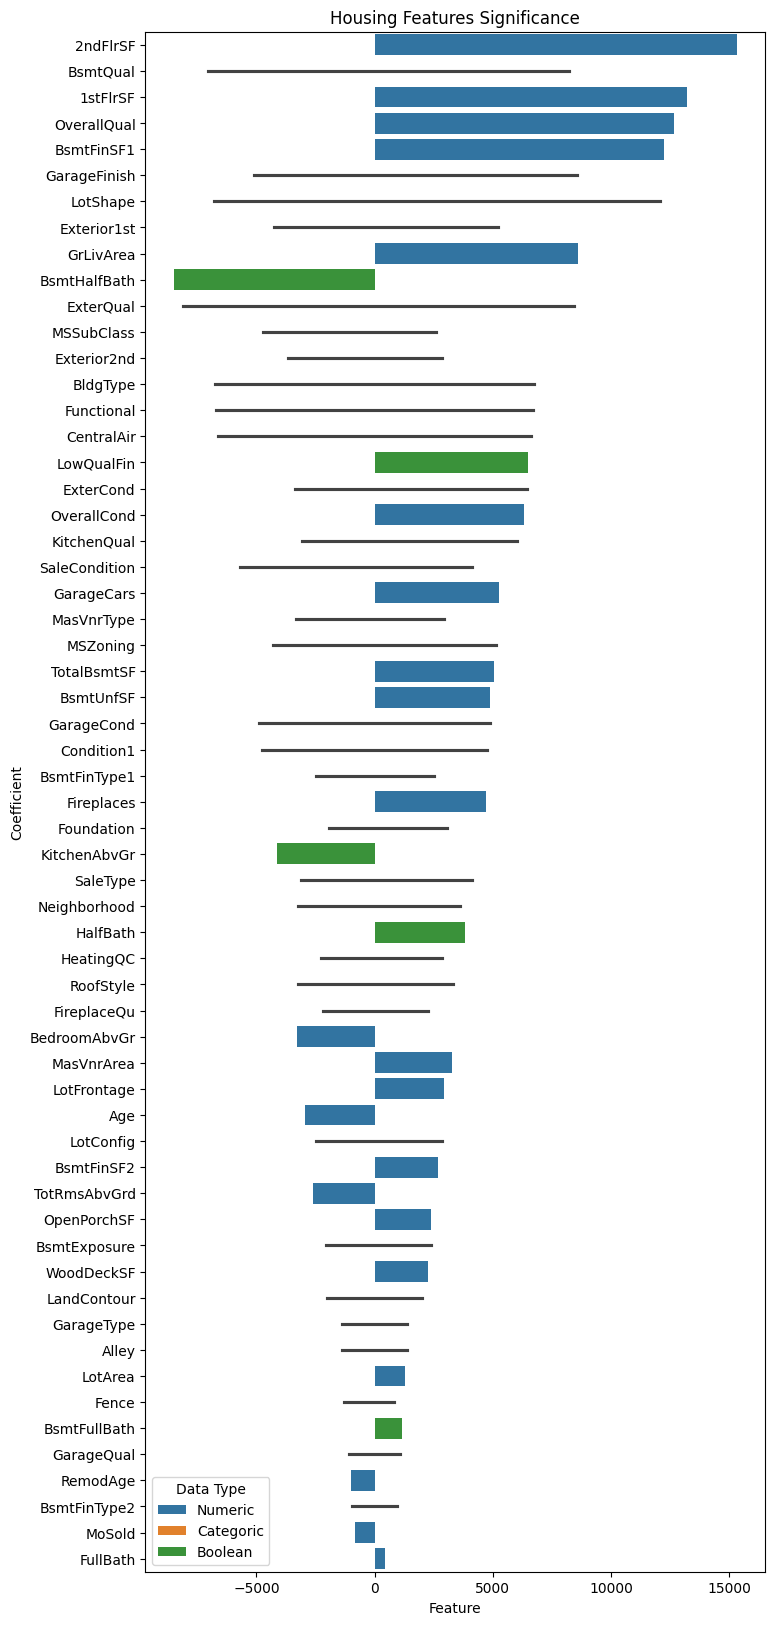

<Figure size 640x480 with 0 Axes>

In [57]:
# Extract the values to plot.
coef_df['Coef Mag'] = np.abs(coef_df['Coefficient'])
# Uncomment the following line if you would like to limit the number of most significant features in the plot below.
# coef_df = coef_df[coef_df['Coef Mag'] > 2000]
cdf = coef_df.sort_values('Coef Mag', ascending=False)

# Split the feature string.
cdf[['Data Type', 'Feature']] = cdf['Feature'].str.split(pat='__',  expand=True)
cdf[['Category', 'Value']] = cdf['Feature'].str.split(pat='_',  expand=True)
# Rename the category values.
cdf['Data Type'] = cdf['Data Type'].replace({'num':'Numeric', 'cat':'Categoric', 'remainder':'Boolean'})

# Create a bar plot of each feature and its impact upon price.
fig, ax = plt.subplots(figsize=(8, 20))
sns.barplot(data=cdf, x='Coefficient', y='Category', hue='Data Type', orient='h', ax=ax)
plt.title('Housing Features Significance')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
# plt.legend(labels=['Numeric', 'Categoric', 'Boolean'])
plt.show()
plt.savefig('images/Feature Significance.jpg');


## Results

The Test RMSE above indicates that our price estimate is off by $26.4k on average, which is a fairly significant proportion of the $180k mean housing price of the dataset.  Thus, futher models should be explored including an ensemble model.  The hope is that this accuracy could be improved.

### Evaluation

Although our dataset has many features that we can evaluate for their impact upon price, we are limited in the total number of rows of data.  More specifically, much of the categorical data is limited in the number of each value that is present in the data.  We delt with this by combining rare data in to a category 'Other'.  This approach is only helpful if the remaining categorical values are significantly different from those that are grouped together.  In the simplest case (with two categorical values), this is a way of stating that a category is either one thing or not that thing.  In other words, this simply reduces the number of columns when one-hot encoding. <br><br>

We should recommend to the client that we need to get more data to refine our model.  At a minimum,  we should get better representation of those feature values that are of interest.  <br><br>


## Deployment

### Report to Client

Although our dataset has many features that we can evaluate for their impact upon price, we are limited in the total number of rows of data.  More specifically, much of the categorical data is limited in the number of each value that is present in the data.  We delt with this by combining rare data in to a category 'Other'.  This approach is only helpful if the remaining categorical values are significantly different from those that are grouped together.  In the simplest case (with two categorical values), this is a way of stating that a category is either one thing or not that thing.  In other words, this simply reduces the number of columns when one-hot encoding. <br><br>

We should collect more data to refine our model.  At a minimum,  we should get better representation of those feature values that are of interest.  <br><br>


My research indicates:

There are many home features that impact price that we cannot change, such as the square footage of the house or the shape of the lot.  However, there are several that we can change.  The most significant of these are the quality factors.  In particular the basement quality, overall quality, and garage finish have significant impact upon the sale price of a home.  These are features that can be changed before a home is put on the market.  This information can be considered when making a purchase of a property.

In addition, there are a few unexpected items that have a negative impact upon the sale price that could be changed (if they are not in good repair).  Among these are having a half-bath in the basement and having a kitchen on an upper floor.  When looking for a property to purchase, these might be features to consider, especially if in disrepair.